In [22]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sp
from scipy.io import loadmat
import mne
import glob
import os
import os
import mimodulo as mm

In [23]:
#Abrir datos
ruta = r"C:\Datasets\Proyecto_Mon\Proyecto\Preprocessed\DecisionMaking\*.mat"
mat_files = {}

for archivo in glob.glob(ruta):
    nombre = os.path.basename(archivo)
    contenido = loadmat(archivo)
    mat_files[nombre] = contenido


In [24]:

if mat_files:
    first_file_name = list(mat_files.keys())[0]
    first_file_content = mat_files[first_file_name]

    print(f"\n--- INSPECCIÓN DETALLADA DE '{first_file_name}' ---")

   
    expected_fields = ('fs', 'x', 'clab', 'y', 'className', 't', 'filename')

    print("\n##### Contenido de 'observer' #####")
    if 'observer' in first_file_content and first_file_content['observer'].shape == (1, 1):
        actual_observer_content = first_file_content['observer'][0, 0]

        if hasattr(actual_observer_content, 'dtype') and actual_observer_content.dtype.names:
            print(f"Campos disponibles en 'observer[0,0]': {actual_observer_content.dtype.names}")

            for field_name in expected_fields:
                if field_name in actual_observer_content.dtype.names:
                    field_value = actual_observer_content[field_name]
                    print(f"  --- Campo: '{field_name}' ---")
                    print(f"    Tipo: {type(field_value)}")
                    if hasattr(field_value, 'shape'):
                        print(f"    Shape: {field_value.shape}")
                    
                    if field_name == 'clab' and hasattr(field_value, 'flatten'):
                        
                        print(f"    Primeros 3 elementos (ejemplo): {field_value.flatten()[:3]}")
                    elif field_value is not None:
                        
                        if np.isscalar(field_value) or (isinstance(field_value, np.ndarray) and field_value.size == 1):
                             print(f"    Valor: {field_value}")
                        elif isinstance(field_value, np.ndarray) and field_value.size > 1:
                            
                            print(f"    Primeros 3 elementos (ejemplo): {field_value.flatten()[:3]}")
                else:
                    print(f"  --- Campo: '{field_name}' (No encontrado en observer[0,0]) ---")
        else:
            print(f"Contenido de 'observer[0,0]' no es una estructura con nombres de campo. Tipo: {type(actual_observer_content)}")
    else:
        print("'observer' no encontrado o no es una estructura (1,1).")


    print("\n##### Contenido de 'player' #####")
    if 'player' in first_file_content and first_file_content['player'].shape == (1, 1):
        actual_player_content = first_file_content['player'][0, 0]

        if hasattr(actual_player_content, 'dtype') and actual_player_content.dtype.names:
            print(f"Campos disponibles en 'player[0,0]': {actual_player_content.dtype.names}")

            for field_name in expected_fields:
                if field_name in actual_player_content.dtype.names:
                    field_value = actual_player_content[field_name]
                    print(f"  --- Campo: '{field_name}' ---")
                    print(f"    Tipo: {type(field_value)}")
                    if hasattr(field_value, 'shape'):
                        print(f"    Shape: {field_value.shape}")
                    if field_name == 'clab' and hasattr(field_value, 'flatten'):
                        print(f"  Primeros 3 elementos (ejemplo): {field_value.flatten()[:3]}")
                    elif field_value is not None:
                        if np.isscalar(field_value) or (isinstance(field_value, np.ndarray) and field_value.size == 1):
                             print(f"    Valor: {field_value}")
                        elif isinstance(field_value, np.ndarray) and field_value.size > 1:
                            print(f"    Primeros 3 elementos (ejemplo): {field_value.flatten()[:3]}")
                else:
                    print(f"  --- Campo: '{field_name}' (No encontrado en player[0,0]) ---")
        else:
            print(f"Contenido de 'player[0,0]' no es una estructura con nombres de campo. Tipo: {type(actual_player_content)}")
    else:
        print("'player' no encontrado o no es una estructura (1,1).")


--- INSPECCIÓN DETALLADA DE 'Player_sub01_Observer_sub02.mat' ---

##### Contenido de 'observer' #####
Campos disponibles en 'observer[0,0]': ('fs', 'x', 'clab', 'y', 'className', 't', 'filename')
  --- Campo: 'fs' ---
    Tipo: <class 'numpy.ndarray'>
    Shape: (1, 1)
    Valor: [[100]]
  --- Campo: 'x' ---
    Tipo: <class 'numpy.ndarray'>
    Shape: (350, 30, 484)
    Primeros 3 elementos (ejemplo): [11.73809814 -4.60339928  4.1760745 ]
  --- Campo: 'clab' ---
    Tipo: <class 'numpy.ndarray'>
    Shape: (1, 30)
    Primeros 3 elementos (ejemplo): [array(['F7'], dtype='<U2') array(['F3'], dtype='<U2')
 array(['Fz'], dtype='<U2')]
  --- Campo: 'y' ---
    Tipo: <class 'numpy.ndarray'>
    Shape: (4, 484)
    Primeros 3 elementos (ejemplo): [0 0 1]
  --- Campo: 'className' ---
    Tipo: <class 'numpy.ndarray'>
    Shape: (1, 4)
    Primeros 3 elementos (ejemplo): [array(['sponL'], dtype='<U5') array(['sponT'], dtype='<U5')
 array(['instL'], dtype='<U5')]
  --- Campo: 't' ---
    Tip

In [25]:
correlation_matrices_observer = {}
correlation_matrices_player = {}
channel_labels = [] 

if mat_files:
    print("\nMatrices de correlación del jugador y su respectivo jugador...")
    for file_name, file_content in mat_files.items():
        try:
            observer_data_struct = file_content['observer'][0, 0]
            raw_clab = observer_data_struct['clab'][0] 
            channel_labels = [str(item[0]) for item in raw_clab]
            eeg_observer_data_3d = observer_data_struct['x'] #(puntos_de_tiempo, canales, épocas)

            # Reestructurar los datos para hacerla de 2 dimensiones y usar np.corrcoef: (canales x (puntos_de_tiempo * épocas))
            eeg_observer_reshaped = np.transpose(eeg_observer_data_3d, (1, 0, 2))
            # Aplanar los puntos en el tiempo y épocas en una sola dimensión para las muestras
            num_channels_obs = eeg_observer_reshaped.shape[0]
            num_samples_per_channel_obs = eeg_observer_reshaped.shape[1] * eeg_observer_reshaped.shape[2]
            eeg_observer_2d = eeg_observer_reshaped.reshape(num_channels_obs, num_samples_per_channel_obs)
            

            # Calcular la matriz de correlación para el observador
            corr_matrix_observer = np.corrcoef(eeg_observer_2d)
            correlation_matrices_observer[file_name] = corr_matrix_observer

            # PLAYER
            player_data_struct = file_content['player'][0, 0]
            eeg_player_data_3d = player_data_struct['x'] 

           
            eeg_player_reshaped = np.transpose(eeg_player_data_3d, (1, 0, 2))
            num_channels_play = eeg_player_reshaped.shape[0]
            num_samples_per_channel_play = eeg_player_reshaped.shape[1] * eeg_player_reshaped.shape[2]
            eeg_player_2d = eeg_player_reshaped.reshape(num_channels_play, num_samples_per_channel_play)

           # Calcular la matriz de correlación para el jugador
            corr_matrix_player = np.corrcoef(eeg_player_2d)
            correlation_matrices_player[file_name] = corr_matrix_player

            print(f"Calculadas matrices de correlación para '{file_name}' (observador y jugador). "
                  f"Shape de datos EEG observador (original 3D): {eeg_observer_data_3d.shape}, "
                  f"Shape 2D para correlación: {eeg_observer_2d.shape}")

        except KeyError as e:
            print(f"Error: La clave {e} no se encontró en el archivo {file_name}. ¿Estructura inesperada?")
        except Exception as e:
            print(f"Ocurrió un error inesperado al procesar {file_name}: {e}")

    print("\n--- Matrices de correlación calculadas para todos ---")


Matrices de correlación del jugador y su respectivo jugador...
Calculadas matrices de correlación para 'Player_sub01_Observer_sub02.mat' (observador y jugador). Shape de datos EEG observador (original 3D): (350, 30, 484), Shape 2D para correlación: (30, 169400)
Calculadas matrices de correlación para 'Player_sub03_Observer_sub06.mat' (observador y jugador). Shape de datos EEG observador (original 3D): (350, 30, 484), Shape 2D para correlación: (30, 169400)
Calculadas matrices de correlación para 'Player_sub04_Observer_sub05.mat' (observador y jugador). Shape de datos EEG observador (original 3D): (350, 30, 484), Shape 2D para correlación: (30, 169400)
Calculadas matrices de correlación para 'Player_sub05_Observer_sub04.mat' (observador y jugador). Shape de datos EEG observador (original 3D): (350, 30, 484), Shape 2D para correlación: (30, 169400)
Calculadas matrices de correlación para 'Player_sub06_Observer_sub03.mat' (observador y jugador). Shape de datos EEG observador (original 3D

In [26]:
# Mostrar DataFrames para el OBSERVADOR
print("\n--- Matrices de Correlación para OBSERVADORES ---")
lista_dfs_observadores = []
for file_name, corr_matrix in correlation_matrices_observer.items():
    print(f"\n**{file_name} (OBSERVADOR)**")
    np.fill_diagonal(corr_matrix, 0) # Eliminar diagonales
    p=np.mean(corr_matrix)
    m=np.max(corr_matrix)
    mn=np.min(corr_matrix)
    print(f" El promedio de la matriz de adyacencia es={p} | max={m} | min={mn}")
    df_obs = pd.DataFrame(corr_matrix)
    if channel_labels:
            df_obs.columns = channel_labels
            df_obs.index = channel_labels
    display(df_obs)
    lista_dfs_observadores.append(df_obs)

    # Mostrar DataFrames para el PLAYER
print("\n--- Matrices de Correlación para PLAYERS ---")
lista_dfs_players = []
for file_name, corr_matrix in correlation_matrices_player.items():
    print(f"\n**{file_name} (PLAYER)**") # Encabezado para cada DataFrame
    np.fill_diagonal(corr_matrix, 0) # Eliminar diagonales
    p=np.mean(corr_matrix)
    m=np.max(corr_matrix)
    mn=np.min(corr_matrix)
    print(f" El promedio de la matriz de adyacencia es={p} | max={m} | min={mn}")
    df_play = pd.DataFrame(corr_matrix)
    if channel_labels:
            df_play.columns = channel_labels
            df_play.index = channel_labels
    display(df_play) 
    lista_dfs_players.append(df_play)


--- Matrices de Correlación para OBSERVADORES ---

**Player_sub01_Observer_sub02.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.021120990239146896 | max=0.9067388687494867 | min=-0.8377722999378253


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.552914,0.178658,0.122604,0.377162,0.639436,0.106931,-0.107348,0.011184,0.420364,...,-0.629567,-0.692986,-0.343619,-0.495286,-0.644251,-0.367424,-0.437591,0.787418,0.559276,0.399234
F3,0.552914,0.000000,0.681477,0.395989,0.095469,0.735887,0.724795,0.403692,0.092363,0.129779,...,-0.300630,-0.522949,-0.563534,-0.536043,-0.632684,-0.546440,-0.599741,0.235729,0.002715,0.284553
Fz,0.178658,0.681477,0.000000,0.722641,0.231484,0.327938,0.773997,0.807485,0.401233,-0.188203,...,-0.145477,-0.308416,-0.543916,-0.620018,-0.556237,-0.658635,-0.642977,-0.090860,-0.026450,0.417330
F4,0.122604,0.395989,0.722641,0.000000,0.545717,0.080637,0.435403,0.775098,0.720659,-0.252658,...,-0.289719,-0.255887,-0.384623,-0.709358,-0.525940,-0.676753,-0.598115,-0.003552,0.224830,0.626695
F8,0.377162,0.095469,0.231484,0.545717,0.000000,-0.004146,-0.100252,0.213438,0.637494,-0.100001,...,-0.553294,-0.366663,-0.137969,-0.656015,-0.497623,-0.512433,-0.434524,0.511482,0.737322,0.752573
FC5,0.639436,0.735887,0.327938,0.080637,-0.004146,0.000000,0.477215,0.053882,-0.145656,0.444236,...,-0.325309,-0.591755,-0.514529,-0.326475,-0.580733,-0.333439,-0.471497,0.399675,-0.001499,0.219618
FC1,0.106931,0.724795,0.773997,0.435403,-0.100252,0.477215,0.000000,0.680619,0.125040,-0.121568,...,0.084255,-0.226402,-0.596073,-0.403303,-0.448088,-0.533018,-0.575640,-0.240030,-0.331319,0.123537
FC2,-0.107348,0.403692,0.807485,0.775098,0.213438,0.053882,0.680619,0.000000,0.557806,-0.373645,...,0.080089,-0.012558,-0.456018,-0.560200,-0.372228,-0.647662,-0.583680,-0.359008,-0.133803,0.330915
FC6,0.011184,0.092363,0.401233,0.720659,0.637494,-0.145656,0.125040,0.557806,0.000000,-0.326314,...,-0.235191,-0.032459,-0.130619,-0.637471,-0.336947,-0.590854,-0.452930,-0.039630,0.364591,0.571569
T7,0.420364,0.129779,-0.188203,-0.252658,-0.100001,0.444236,-0.121568,-0.373645,-0.326314,0.000000,...,-0.309458,-0.446384,-0.155970,0.036204,-0.273540,0.092512,-0.077764,0.463816,0.034875,0.061487



**Player_sub03_Observer_sub06.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.014201265961266004 | max=0.8987925608819015 | min=-0.5668784895588878


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.348288,0.102218,0.003201,0.185229,0.207493,0.116661,-0.128736,-0.017870,0.222756,...,-0.394991,-0.403351,-0.210429,-0.224888,-0.119836,-0.387185,-0.070374,0.095848,0.326497,0.243379
F3,0.348288,0.000000,0.552432,0.136606,0.057069,0.272405,0.589431,0.261078,-0.012114,0.045544,...,-0.258981,-0.406093,-0.290221,-0.249224,-0.094157,-0.420108,-0.071096,-0.017659,0.086754,0.252705
Fz,0.102218,0.552432,0.000000,0.358583,0.076719,0.173191,0.810348,0.745202,0.154974,-0.144882,...,-0.209635,-0.360675,-0.301772,-0.358735,-0.103061,-0.439364,-0.109783,-0.093631,-0.004746,0.480862
F4,0.003201,0.136606,0.358583,0.000000,0.189043,-0.019898,0.202909,0.427489,0.160239,-0.139710,...,-0.220163,-0.152107,-0.101240,-0.305310,-0.105788,-0.227147,-0.127981,-0.024293,0.005508,0.193432
F8,0.185229,0.057069,0.076719,0.189043,0.000000,-0.079205,-0.104437,0.005570,-0.096300,-0.099667,...,-0.355746,-0.146522,0.016719,-0.346006,-0.127812,-0.204009,-0.176794,0.284240,0.249596,0.400876
FC5,0.207493,0.272405,0.173191,-0.019898,-0.079205,0.000000,0.388720,0.014045,0.069847,0.161701,...,-0.205393,-0.234680,-0.138050,-0.160591,-0.230836,-0.265928,-0.179292,-0.368020,-0.157968,-0.006957
FC1,0.116661,0.589431,0.810348,0.202909,-0.104437,0.388720,0.000000,0.636424,-0.004979,-0.037776,...,-0.011669,-0.357465,-0.361674,-0.208048,-0.138883,-0.427530,-0.117030,-0.214270,-0.167246,0.160761
FC2,-0.128736,0.261078,0.745202,0.427489,0.005570,0.014045,0.636424,0.000000,0.406025,-0.265339,...,-0.020153,-0.036396,-0.126920,-0.388825,-0.216864,-0.226383,-0.246759,-0.253429,-0.220281,0.171282
FC6,-0.017870,-0.012114,0.154974,0.160239,-0.096300,0.069847,-0.004979,0.406025,0.000000,-0.151878,...,-0.240007,0.127608,0.126778,-0.389140,-0.276497,-0.045123,-0.331969,-0.167577,-0.316364,0.058050
T7,0.222756,0.045544,-0.144882,-0.139710,-0.099667,0.161701,-0.037776,-0.265339,-0.151878,0.000000,...,-0.254587,-0.296219,-0.185385,-0.121459,-0.102239,-0.269974,-0.061950,0.233742,-0.026405,-0.151976



**Player_sub04_Observer_sub05.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.0061484321382129555 | max=0.9939866882841476 | min=-0.7362810322334105


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.383547,0.131913,0.043861,0.279716,0.145235,-0.020024,-0.245932,-0.043422,0.256363,...,-0.544126,-0.606496,-0.341391,-0.433294,-0.342355,-0.503639,-0.503127,0.653674,0.442042,0.257099
F3,0.383547,0.000000,0.626141,0.271878,0.100303,0.480122,0.618801,0.164961,-0.024557,0.166958,...,-0.431591,-0.643316,-0.563906,-0.515004,-0.517012,-0.636802,-0.635556,0.318633,0.061977,0.146364
Fz,0.131913,0.626141,0.000000,0.508215,0.111535,0.232183,0.800361,0.679403,0.187868,-0.100825,...,-0.237850,-0.445343,-0.586001,-0.552713,-0.622825,-0.592026,-0.592799,0.053643,-0.096077,0.088855
F4,0.043861,0.271878,0.508215,0.000000,0.283377,0.088408,0.263016,0.564144,0.537113,-0.124968,...,-0.290886,-0.274711,-0.276858,-0.460644,-0.434198,-0.378339,-0.378032,0.115619,0.099602,-0.223485
F8,0.279716,0.100303,0.111535,0.283377,0.000000,-0.047093,-0.166270,-0.051866,0.336749,-0.061029,...,-0.553488,-0.408724,-0.131798,-0.567795,-0.423146,-0.405047,-0.404508,0.559344,0.625881,0.307587
FC5,0.145235,0.480122,0.232183,0.088408,-0.047093,0.000000,0.311198,-0.010946,-0.106737,0.292941,...,-0.279138,-0.437117,-0.376904,-0.240176,-0.267822,-0.403700,-0.402694,0.145848,-0.032332,0.012240
FC1,-0.020024,0.618801,0.800361,0.263016,-0.166270,0.311198,0.000000,0.626930,-0.031535,-0.050909,...,0.033589,-0.297681,-0.576290,-0.282237,-0.456671,-0.449899,-0.450811,-0.147735,-0.342650,-0.093854
FC2,-0.245932,0.164961,0.679403,0.564144,-0.051866,-0.010946,0.626930,0.000000,0.336538,-0.289298,...,0.190017,0.065185,-0.342131,-0.282094,-0.433197,-0.237453,-0.240156,-0.347602,-0.319944,-0.260377
FC6,-0.043422,-0.024557,0.187868,0.537113,0.336749,-0.106737,-0.031535,0.336538,0.000000,-0.180207,...,-0.259557,-0.089649,-0.024187,-0.404253,-0.341706,-0.216904,-0.216723,0.054916,0.165163,-0.030708
T7,0.256363,0.166958,-0.100825,-0.124968,-0.061029,0.292941,-0.050909,-0.289298,-0.180207,0.000000,...,-0.260907,-0.343415,-0.178062,-0.045238,-0.024006,-0.243865,-0.241773,0.298437,0.047276,0.017696



**Player_sub05_Observer_sub04.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02483073138484862 | max=0.9298428540664111 | min=-0.7679518803079083


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.544379,0.139220,0.149085,0.311247,0.511833,-0.007703,-0.163153,0.027705,0.456238,...,-0.611074,-0.628204,-0.322996,-0.460376,-0.307533,-0.573344,-0.438474,0.696969,0.407744,0.596973
F3,0.544379,0.000000,0.556445,0.409808,0.159927,0.577375,0.479549,0.314520,0.166818,0.200862,...,-0.417738,-0.532039,-0.520468,-0.539787,-0.480958,-0.594128,-0.589358,0.295317,0.109056,0.319475
Fz,0.139220,0.556445,0.000000,0.553352,0.099347,0.330944,0.823399,0.803193,0.301270,-0.230470,...,-0.173167,-0.335105,-0.582992,-0.519858,-0.579790,-0.550069,-0.639170,-0.070418,-0.010870,0.182144
F4,0.149085,0.409808,0.553352,0.000000,0.442549,0.145187,0.334320,0.554732,0.666993,-0.226540,...,-0.348354,-0.316803,-0.375127,-0.659039,-0.644578,-0.521516,-0.590068,0.064085,0.394160,0.446213
F8,0.311247,0.159927,0.099347,0.442549,0.000000,0.026176,-0.119647,-0.014038,0.493607,-0.050265,...,-0.478141,-0.367300,-0.095367,-0.518121,-0.416013,-0.462224,-0.389165,0.318665,0.671245,0.630371
FC5,0.511833,0.577375,0.330944,0.145187,0.026176,0.000000,0.360220,0.098161,-0.018174,0.393484,...,-0.391529,-0.534434,-0.477021,-0.390178,-0.353357,-0.531917,-0.501377,0.413556,0.031608,0.278985
FC1,-0.007703,0.479549,0.823399,0.334320,-0.119647,0.360220,0.000000,0.770947,0.096476,-0.210597,...,0.060590,-0.201816,-0.596959,-0.305950,-0.433535,-0.416163,-0.541819,-0.244255,-0.294008,-0.109225
FC2,-0.163153,0.314520,0.803193,0.554732,-0.014038,0.098161,0.770947,0.000000,0.407078,-0.427015,...,0.057611,-0.063639,-0.484243,-0.430732,-0.555404,-0.361290,-0.532558,-0.323879,-0.094473,0.014646
FC6,0.027705,0.166818,0.301270,0.666993,0.493607,-0.018174,0.096476,0.407078,0.000000,-0.260124,...,-0.331726,-0.223295,-0.122832,-0.577414,-0.532972,-0.421163,-0.441816,-0.039322,0.489364,0.436158
T7,0.456238,0.200862,-0.230470,-0.226540,-0.050265,0.393484,-0.210597,-0.427015,-0.260124,0.000000,...,-0.414594,-0.413729,-0.010713,-0.020837,0.162744,-0.206661,-0.036941,0.443306,-0.076827,0.091180



**Player_sub06_Observer_sub03.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.024020983260976563 | max=0.973430508142366 | min=-0.8741477405493246


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.762668,0.266202,0.041588,0.010511,0.840991,0.212210,-0.119476,-0.232349,0.714465,...,-0.500651,-0.611518,-0.487680,-0.367780,-0.357215,-0.575038,-0.500934,0.768796,0.116916,0.185701
F3,0.762668,0.000000,0.775291,0.546015,0.366668,0.785159,0.667987,0.450466,0.149155,0.279995,...,-0.508663,-0.693388,-0.742863,-0.633080,-0.677837,-0.779144,-0.809734,0.298191,0.320994,0.516082
Fz,0.266202,0.775291,0.000000,0.909615,0.681109,0.263815,0.756378,0.844910,0.509088,-0.284213,...,-0.369611,-0.582700,-0.759293,-0.700798,-0.807449,-0.763750,-0.874148,-0.039503,0.545629,0.785086
F4,0.041588,0.546015,0.909615,0.000000,0.897083,0.047574,0.473174,0.774997,0.748572,-0.474826,...,-0.413369,-0.519982,-0.551452,-0.633750,-0.771896,-0.695894,-0.777058,-0.121574,0.780029,0.910431
F8,0.010511,0.366668,0.681109,0.897083,0.000000,-0.001630,0.166502,0.507295,0.864951,-0.414686,...,-0.547298,-0.572745,-0.325105,-0.557548,-0.692571,-0.676821,-0.671043,-0.016110,0.966683,0.870123
FC5,0.840991,0.785159,0.263815,0.047574,-0.001630,0.000000,0.237272,-0.041353,-0.120593,0.609336,...,-0.415562,-0.443683,-0.339949,-0.307697,-0.287853,-0.428819,-0.384479,0.339649,0.026378,0.081994
FC1,0.212210,0.667987,0.756378,0.473174,0.166502,0.237272,0.000000,0.761451,0.142591,-0.109458,...,-0.128610,-0.362300,-0.659440,-0.611326,-0.608428,-0.539588,-0.678884,-0.142808,0.015003,0.230868
FC2,-0.119476,0.450466,0.844910,0.774997,0.507295,-0.041353,0.761451,0.000000,0.582741,-0.578194,...,-0.062418,-0.155654,-0.440412,-0.657408,-0.725279,-0.442698,-0.634086,-0.350619,0.305078,0.482407
FC6,-0.232349,0.149155,0.509088,0.748572,0.864951,-0.120593,0.142591,0.582741,0.000000,-0.587212,...,-0.421846,-0.211980,0.063990,-0.601204,-0.681353,-0.434911,-0.479276,-0.256517,0.785687,0.557226
T7,0.714465,0.279995,-0.284213,-0.474826,-0.414686,0.609336,-0.109458,-0.578194,-0.587212,0.000000,...,-0.326519,-0.365408,-0.179969,0.020957,0.145330,-0.206808,-0.063513,0.575680,-0.267757,-0.282799



**Player_sub07_Observer_sub08.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.015157786419529085 | max=0.9419907121593709 | min=-0.6830730217255561


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.806640,0.145308,-0.514592,-0.525902,0.930646,0.374240,-0.255120,-0.594330,0.814435,...,-0.126453,-0.435781,-0.402006,0.041027,-0.060718,-0.334149,-0.271262,0.917678,-0.683073,-0.481047
F3,0.806640,0.000000,0.425470,-0.260307,-0.412323,0.737823,0.538710,0.019641,-0.385268,0.486843,...,-0.193406,-0.444131,-0.386804,-0.113002,-0.189802,-0.395251,-0.322918,0.627840,-0.493239,-0.532314
Fz,0.145308,0.425470,0.000000,0.413945,0.054661,0.086235,0.629617,0.697598,0.206476,-0.118416,...,-0.258478,-0.357071,-0.415008,-0.485869,-0.532132,-0.486874,-0.515310,0.017984,0.038789,-0.091249
F4,-0.514592,-0.260307,0.413945,0.000000,0.424670,-0.452632,0.049922,0.730748,0.849038,-0.526726,...,-0.315917,-0.094531,-0.025386,-0.539875,-0.482546,-0.292865,-0.308231,-0.552966,0.637837,0.054784
F8,-0.525902,-0.412323,0.054661,0.424670,0.000000,-0.571619,-0.262441,0.195573,0.502077,-0.416291,...,-0.394739,-0.176969,0.011087,-0.486582,-0.380237,-0.265541,-0.223347,-0.360760,0.743244,0.709931
FC5,0.930646,0.737823,0.086235,-0.452632,-0.571619,0.000000,0.338516,-0.279134,-0.538103,0.636499,...,-0.115228,-0.389481,-0.305324,0.106155,0.027513,-0.267151,-0.172246,0.762202,-0.649909,-0.552980
FC1,0.374240,0.538710,0.629617,0.049922,-0.262441,0.338516,0.000000,0.418131,-0.150560,0.071880,...,0.009455,-0.280513,-0.489309,-0.188730,-0.312226,-0.345870,-0.407017,0.205858,-0.313458,-0.263757
FC2,-0.255120,0.019641,0.697598,0.730748,0.195573,-0.279134,0.418131,0.000000,0.559007,-0.452600,...,-0.125961,-0.060061,-0.266707,-0.532425,-0.574278,-0.324804,-0.473462,-0.364383,0.271652,0.035090
FC6,-0.594330,-0.385268,0.206476,0.849038,0.502077,-0.538103,-0.150560,0.559007,0.000000,-0.583194,...,-0.352437,-0.031294,0.092238,-0.565916,-0.480190,-0.243432,-0.262939,-0.573214,0.733404,0.309670
T7,0.814435,0.486843,-0.118416,-0.526726,-0.416291,0.636499,0.071880,-0.452600,-0.583194,0.000000,...,-0.140462,-0.386150,-0.253134,0.145064,0.110209,-0.218494,-0.095555,0.941991,-0.537387,-0.296877



**Player_sub08_Observer_sub07.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.029878401596732575 | max=0.9886823827348833 | min=-0.8197157651239625


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.584639,0.357608,0.216175,0.369834,0.483245,0.293005,-0.035005,0.134016,0.405096,...,-0.622307,-0.501739,-0.365791,-0.506479,-0.488336,-0.451715,-0.465095,0.604726,0.526092,0.563267
F3,0.584639,0.000000,0.919179,0.516724,0.280984,0.659290,0.834075,0.346396,0.164872,0.126255,...,-0.595447,-0.582924,-0.626300,-0.667434,-0.667822,-0.569223,-0.661403,0.347350,0.275914,0.560579
Fz,0.357608,0.919179,0.000000,0.640174,0.236396,0.374862,0.792713,0.515782,0.261814,-0.049551,...,-0.478135,-0.457669,-0.567131,-0.654954,-0.662261,-0.500942,-0.609821,0.195772,0.155739,0.485006
F4,0.216175,0.516724,0.640174,0.000000,0.289872,0.147845,0.338634,0.452620,0.542332,-0.108694,...,-0.480129,-0.331288,-0.357861,-0.592161,-0.590777,-0.401048,-0.478989,0.196210,0.241761,0.504138
F8,0.369834,0.280984,0.236396,0.289872,0.000000,0.095564,0.021582,0.020580,0.406421,0.037597,...,-0.562331,-0.351582,-0.179844,-0.540906,-0.527808,-0.372133,-0.403265,0.532882,0.677711,0.772396
FC5,0.483245,0.659290,0.374862,0.147845,0.095564,0.000000,0.527335,0.032298,-0.021994,0.275701,...,-0.433017,-0.451544,-0.443913,-0.365938,-0.364365,-0.407721,-0.431419,0.149093,0.136366,0.315724
FC1,0.293005,0.834075,0.792713,0.338634,0.021582,0.527335,0.000000,0.415046,0.021082,-0.002505,...,-0.298643,-0.421887,-0.595038,-0.471258,-0.488807,-0.457373,-0.539643,0.039243,-0.064888,0.255697
FC2,-0.035005,0.346396,0.515782,0.452620,0.020580,0.032298,0.415046,0.000000,0.212288,-0.211782,...,-0.141174,-0.150113,-0.317839,-0.397016,-0.413238,-0.260398,-0.332014,-0.143146,-0.078678,0.156172
FC6,0.134016,0.164872,0.261814,0.542332,0.406421,-0.021994,0.021082,0.212288,0.000000,-0.104664,...,-0.429260,-0.215381,-0.131504,-0.508072,-0.501963,-0.301861,-0.343841,0.186817,0.308000,0.605758
T7,0.405096,0.126255,-0.049551,-0.108694,0.037597,0.275701,-0.002505,-0.211782,-0.104664,0.000000,...,-0.300403,-0.279082,-0.170260,-0.081448,-0.064254,-0.219058,-0.169680,0.440898,0.148175,0.174129



**Player_sub09_Observer_sub10.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02656762422827465 | max=0.9710580514324545 | min=-0.7656625549070779


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.543135,0.355552,0.338365,0.620627,0.729461,0.222099,0.012799,0.196976,0.653154,...,-0.714479,-0.765663,-0.472393,-0.544871,-0.480315,-0.669176,-0.542302,0.971058,0.667506,0.788932
F3,0.543135,0.000000,0.769254,0.489495,0.248594,0.692693,0.752349,0.484092,0.128377,0.248169,...,-0.452174,-0.626436,-0.583265,-0.581695,-0.569129,-0.633789,-0.623632,0.371544,0.153602,0.472676
Fz,0.355552,0.769254,0.000000,0.727857,0.331529,0.458661,0.842138,0.796956,0.306874,0.013362,...,-0.402458,-0.555139,-0.593281,-0.651977,-0.641261,-0.627091,-0.656619,0.161988,0.152154,0.511292
F4,0.338365,0.489495,0.727857,0.000000,0.616308,0.260440,0.482898,0.719025,0.607670,-0.084857,...,-0.492518,-0.469319,-0.451874,-0.650154,-0.619242,-0.571115,-0.591331,0.200883,0.377873,0.648229
F8,0.620627,0.248594,0.331529,0.616308,0.000000,0.195979,0.037842,0.233588,0.672551,0.028081,...,-0.656988,-0.469678,-0.242462,-0.574072,-0.500154,-0.503306,-0.438646,0.568934,0.733409,0.903944
FC5,0.729461,0.692693,0.458661,0.260440,0.195979,0.000000,0.488028,0.155358,-0.004269,0.597868,...,-0.493557,-0.673884,-0.539533,-0.456151,-0.442767,-0.622277,-0.572166,0.633997,0.172680,0.475022
FC1,0.222099,0.752349,0.842138,0.482898,0.037842,0.488028,0.000000,0.742202,0.069560,0.025390,...,-0.190991,-0.466026,-0.607395,-0.545458,-0.567842,-0.549488,-0.618022,0.031419,-0.085931,0.297063
FC2,0.012799,0.484092,0.796956,0.719025,0.233588,0.155358,0.742202,0.000000,0.380441,-0.232911,...,-0.161169,-0.282742,-0.501099,-0.590443,-0.603614,-0.467322,-0.574134,-0.145911,0.022718,0.348536
FC6,0.196976,0.128377,0.306874,0.607670,0.672551,-0.004269,0.069560,0.380441,0.000000,-0.159662,...,-0.423842,-0.210631,-0.161166,-0.506413,-0.465551,-0.340609,-0.357659,0.135770,0.464417,0.601213
T7,0.653154,0.248169,0.013362,-0.084857,0.028081,0.597868,0.025390,-0.232911,-0.159662,0.000000,...,-0.385592,-0.520216,-0.315576,-0.118255,-0.104412,-0.413185,-0.313956,0.728256,0.106037,0.237882



**Player_sub10_Observer_sub09.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.028602047613453925 | max=0.9982811639988342 | min=-0.7640173064697708


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.721532,0.280204,0.223438,0.413771,0.750593,0.119086,-0.076536,0.102125,0.614315,...,-0.703140,-0.707954,-0.385609,-0.539594,-0.448609,-0.542105,-0.538733,0.930837,0.607016,0.648967
F3,0.721532,0.000000,0.656369,0.393038,0.302129,0.758533,0.600499,0.346133,0.151992,0.333681,...,-0.545430,-0.719448,-0.597308,-0.568571,-0.573303,-0.674978,-0.673187,0.560795,0.295564,0.470251
Fz,0.280204,0.656369,0.000000,0.709918,0.389610,0.354846,0.840487,0.819202,0.401602,-0.109046,...,-0.369387,-0.570568,-0.612812,-0.605825,-0.651166,-0.677873,-0.678092,0.116255,0.201678,0.436934
F4,0.223438,0.393038,0.709918,0.000000,0.770425,0.139172,0.468712,0.722325,0.762440,-0.229544,...,-0.474121,-0.488533,-0.442286,-0.694230,-0.686328,-0.644557,-0.644766,0.131305,0.543364,0.663489
F8,0.413771,0.302129,0.389610,0.770425,0.000000,0.162043,0.102209,0.330429,0.776624,-0.066945,...,-0.634109,-0.502117,-0.255852,-0.702464,-0.624284,-0.574308,-0.573009,0.409150,0.881410,0.844535
FC5,0.750593,0.758533,0.354846,0.139172,0.162043,0.000000,0.357906,0.041081,-0.029662,0.602979,...,-0.536920,-0.683106,-0.493547,-0.411406,-0.407531,-0.561381,-0.558725,0.667268,0.238492,0.413650
FC1,0.119086,0.600499,0.840487,0.468712,0.102209,0.357906,0.000000,0.786719,0.180276,-0.120254,...,-0.114929,-0.466629,-0.645151,-0.421240,-0.545858,-0.608860,-0.610071,-0.072820,-0.093432,0.171806
FC2,-0.076536,0.346133,0.819202,0.722325,0.330429,0.041081,0.786719,0.000000,0.505464,-0.384683,...,-0.096749,-0.302434,-0.508913,-0.512572,-0.603530,-0.559040,-0.561458,-0.231584,0.054429,0.257965
FC6,0.102125,0.151992,0.401602,0.762440,0.776624,-0.029662,0.180276,0.505464,0.000000,-0.275530,...,-0.430721,-0.292616,-0.192362,-0.634805,-0.608340,-0.497514,-0.498104,0.055555,0.616676,0.595452
T7,0.614315,0.333681,-0.109046,-0.229544,-0.066945,0.602979,-0.120254,-0.384683,-0.275530,0.000000,...,-0.430009,-0.468058,-0.170839,-0.061807,-0.003101,-0.230088,-0.225695,0.694650,0.114816,0.209162



**Player_sub11_Observer_sub12.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02613553184844222 | max=0.9046165157251299 | min=-0.7406747117118523


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.403434,0.328691,0.085482,0.257954,0.240478,0.368875,0.199447,0.087858,0.460072,...,-0.439536,-0.498121,-0.371886,-0.391554,-0.369231,-0.439741,-0.360246,0.611130,0.349920,0.118460
F3,0.403434,0.000000,0.648995,0.290514,0.239513,0.638728,0.816820,0.508987,0.153361,0.005890,...,-0.475195,-0.583017,-0.526671,-0.536613,-0.575713,-0.574572,-0.556135,0.490511,0.311592,-0.005572
Fz,0.328691,0.648995,0.000000,0.630139,0.387870,0.279032,0.836799,0.825655,0.426471,-0.117881,...,-0.481983,-0.510261,-0.510261,-0.630186,-0.652261,-0.567759,-0.581808,0.430313,0.471048,-0.045568
F4,0.085482,0.290514,0.630139,0.000000,0.204605,0.045793,0.445717,0.643821,0.544463,-0.114790,...,-0.336533,-0.282676,-0.285572,-0.423676,-0.424537,-0.349444,-0.362898,0.139796,0.287429,-0.361934
F8,0.257954,0.239513,0.387870,0.204605,0.000000,0.022726,0.303163,0.387199,0.619445,0.064453,...,-0.552121,-0.393484,-0.236860,-0.538099,-0.486276,-0.430450,-0.376525,0.458232,0.766667,0.377708
FC5,0.240478,0.638728,0.279032,0.045793,0.022726,0.000000,0.459467,0.145685,-0.060546,0.045046,...,-0.310573,-0.474153,-0.402617,-0.265325,-0.323988,-0.428314,-0.392987,0.181069,-0.024924,0.063423
FC1,0.368875,0.816820,0.836799,0.445717,0.303163,0.459467,0.000000,0.818416,0.254860,-0.172428,...,-0.413452,-0.565948,-0.629523,-0.640819,-0.710943,-0.642436,-0.678694,0.448715,0.338349,0.172724
FC2,0.199447,0.508987,0.825655,0.643821,0.387199,0.145685,0.818416,0.000000,0.517679,-0.261952,...,-0.320535,-0.363237,-0.535705,-0.670690,-0.721755,-0.550804,-0.633227,0.246656,0.404498,0.133868
FC6,0.087858,0.153361,0.426471,0.544463,0.619445,-0.060546,0.254860,0.517679,0.000000,-0.100970,...,-0.434207,-0.214152,-0.171920,-0.515197,-0.481888,-0.338849,-0.340540,0.161111,0.657541,0.146844
T7,0.460072,0.005890,-0.117881,-0.114790,0.064453,0.045046,-0.172428,-0.261952,-0.100970,0.000000,...,-0.246450,-0.317950,-0.157560,-0.036493,-0.026906,-0.216666,-0.109976,0.660298,0.208591,0.125873



**Player_sub12_Observer_sub11.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=0.0013556640575723832 | max=0.9992579668803139 | min=-0.7072512194027568


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.738769,0.389072,0.321397,0.352222,0.738676,0.306634,0.143621,0.220989,0.555492,...,-0.505966,-0.558334,-0.220187,-0.467242,-0.430689,-0.539187,-0.536644,0.875985,0.516451,0.551124
F3,0.738769,0.000000,0.575970,0.340933,0.281201,0.614593,0.538507,0.308215,0.149416,0.302397,...,-0.383756,-0.512198,-0.278204,-0.441597,-0.408505,-0.489355,-0.486653,0.687714,0.386761,0.553134
Fz,0.389072,0.575970,0.000000,0.536008,0.335811,0.313533,0.765168,0.720147,0.264883,0.028200,...,-0.270159,-0.443056,-0.276317,-0.484997,-0.452981,-0.484088,-0.481547,0.358406,0.389736,0.612003
F4,0.321397,0.340933,0.536008,0.000000,0.654793,0.192717,0.303415,0.647795,0.625202,0.038625,...,-0.397255,-0.375399,-0.029966,-0.552490,-0.512296,-0.469535,-0.467547,0.366332,0.681615,0.753488
F8,0.352222,0.281201,0.335811,0.654793,0.000000,0.235499,0.145306,0.379962,0.635345,0.156379,...,-0.444533,-0.377634,0.107053,-0.567329,-0.526915,-0.475875,-0.474055,0.456365,0.745674,0.729096
FC5,0.738676,0.614593,0.313533,0.192717,0.235499,0.000000,0.315985,0.123329,0.126632,0.420920,...,-0.372088,-0.495151,-0.253052,-0.354851,-0.329252,-0.465263,-0.462665,0.731235,0.368502,0.461390
FC1,0.306634,0.538507,0.765168,0.303415,0.145306,0.315985,0.000000,0.630030,0.084715,-0.001623,...,-0.100726,-0.405365,-0.342727,-0.404497,-0.386766,-0.463384,-0.461245,0.254992,0.177010,0.360430
FC2,0.143621,0.308215,0.720147,0.647795,0.379962,0.123329,0.630030,0.000000,0.396269,-0.109372,...,-0.185741,-0.292942,-0.155198,-0.512115,-0.483925,-0.454212,-0.452445,0.135377,0.375922,0.470428
FC6,0.220989,0.149416,0.264883,0.625202,0.635345,0.126632,0.084715,0.396269,0.000000,0.045961,...,-0.388139,-0.254563,0.186213,-0.518722,-0.482830,-0.394022,-0.392784,0.291554,0.718387,0.611424
T7,0.555492,0.302397,0.028200,0.038625,0.156379,0.420920,-0.001623,-0.109372,0.045961,0.000000,...,-0.320700,-0.373055,-0.140679,-0.197757,-0.181976,-0.348008,-0.346441,0.665406,0.305675,0.323014



**Player_sub13_Observer_sub14.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.030505772702828823 | max=0.9885106852889644 | min=-0.7318989674123532


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.534251,0.177054,-0.049625,0.096762,0.597104,0.145157,-0.094768,-0.060500,0.513528,...,-0.381487,-0.479738,-0.321300,-0.322855,-0.282625,-0.417449,-0.403393,0.964684,0.292595,-0.016964
F3,0.534251,0.000000,0.613218,0.334169,0.203926,0.486986,0.586568,0.292852,0.145179,0.217355,...,-0.408680,-0.626507,-0.539259,-0.541329,-0.500058,-0.631557,-0.619358,0.596094,0.463418,0.058609
Fz,0.177054,0.613218,0.000000,0.710806,0.272955,0.237524,0.818292,0.756472,0.423718,-0.053809,...,-0.362183,-0.647606,-0.642995,-0.692023,-0.655238,-0.731899,-0.725499,0.250551,0.450061,0.414295
F4,-0.049625,0.334169,0.710806,0.000000,0.187493,0.013262,0.511271,0.760107,0.686821,-0.158289,...,-0.296910,-0.400287,-0.409917,-0.555819,-0.518756,-0.523587,-0.522825,0.001018,0.199073,-0.018142
F8,0.096762,0.203926,0.272955,0.187493,0.000000,0.140967,0.141903,0.150959,0.115238,-0.012691,...,-0.204293,-0.239841,-0.164411,-0.346680,-0.346990,-0.300205,-0.299089,0.120934,0.063369,0.212784
FC5,0.597104,0.486986,0.237524,0.013262,0.140967,0.000000,0.248095,-0.040027,-0.057508,0.527555,...,-0.313837,-0.539037,-0.427180,-0.339200,-0.316674,-0.473985,-0.460156,0.636621,0.209585,0.263064
FC1,0.145157,0.586568,0.818292,0.511271,0.141903,0.248095,0.000000,0.654207,0.226789,-0.038945,...,-0.212666,-0.625664,-0.683403,-0.587206,-0.576955,-0.691528,-0.685913,0.183529,0.269122,0.443341
FC2,-0.094768,0.292852,0.756472,0.760107,0.150959,-0.040027,0.654207,0.000000,0.527128,-0.278644,...,-0.159030,-0.378704,-0.509844,-0.584745,-0.572844,-0.547200,-0.552703,-0.081983,0.143232,0.291549
FC6,-0.060500,0.145179,0.423718,0.686821,0.115238,-0.057508,0.226789,0.527128,0.000000,-0.167691,...,-0.292862,-0.199550,-0.173674,-0.409302,-0.359746,-0.340535,-0.343309,-0.035848,-0.199298,-0.031709
T7,0.513528,0.217355,-0.053809,-0.158289,-0.012691,0.527555,-0.038945,-0.278644,-0.167691,0.000000,...,-0.269759,-0.427951,-0.263812,-0.081633,-0.058866,-0.307510,-0.290440,0.668151,0.074454,0.130872



**Player_sub14_Observer_sub13.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.022043579862893983 | max=0.998360301058669 | min=-0.7395727464101082


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.755634,0.434114,0.188620,0.427839,0.943040,0.336132,0.026703,0.120576,0.754931,...,-0.697610,-0.739573,-0.495924,-0.475171,-0.453066,-0.612228,-0.611178,0.944638,0.444689,0.682761
F3,0.755634,0.000000,0.672930,0.343000,0.274553,0.722898,0.621225,0.319561,0.091783,0.341115,...,-0.506065,-0.644116,-0.554084,-0.495916,-0.508842,-0.603636,-0.603247,0.564990,0.273053,0.629855
Fz,0.434114,0.672930,0.000000,0.693364,0.358449,0.403681,0.841724,0.780721,0.364802,0.052887,...,-0.417807,-0.572990,-0.589496,-0.629176,-0.646940,-0.668014,-0.667852,0.265120,0.247258,0.565278
F4,0.188620,0.343000,0.693364,0.000000,0.394874,0.116015,0.478028,0.748865,0.621932,-0.092336,...,-0.371967,-0.335416,-0.355048,-0.559023,-0.538716,-0.494124,-0.494274,0.100377,0.265455,0.355852
F8,0.427839,0.274553,0.358449,0.394874,0.000000,0.224509,0.103577,0.260751,0.728423,0.194644,...,-0.599466,-0.409007,-0.183678,-0.609120,-0.528177,-0.510311,-0.508980,0.504332,0.757813,0.765047
FC5,0.943040,0.722898,0.403681,0.116015,0.224509,0.000000,0.436695,0.048397,-0.021865,0.682891,...,-0.560572,-0.700747,-0.536339,-0.378032,-0.402754,-0.583162,-0.582241,0.827659,0.226040,0.488640
FC1,0.336132,0.621225,0.841724,0.478028,0.103577,0.436695,0.000000,0.731712,0.123355,0.048564,...,-0.223496,-0.529374,-0.631666,-0.500666,-0.575274,-0.627314,-0.627648,0.139584,-0.010909,0.337053
FC2,0.026703,0.319561,0.780721,0.748865,0.260751,0.048397,0.731712,0.000000,0.494138,-0.251704,...,-0.134903,-0.259073,-0.463526,-0.580805,-0.619176,-0.543270,-0.544284,-0.099045,0.067834,0.307332
FC6,0.120576,0.091783,0.364802,0.621932,0.728423,-0.021865,0.123355,0.494138,0.000000,-0.114015,...,-0.419937,-0.136485,-0.101773,-0.637136,-0.578434,-0.433801,-0.434141,0.164732,0.605187,0.512714
T7,0.754931,0.341115,0.052887,-0.092336,0.194644,0.682891,0.048564,-0.251704,-0.114015,0.000000,...,-0.496576,-0.603285,-0.374071,-0.141407,-0.149373,-0.413631,-0.412250,0.834879,0.328622,0.453739



**Player_sub15_Observer_sub16.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.026882131309641212 | max=0.9404250125742436 | min=-0.6905936126088045


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.367789,0.342660,0.082888,0.087176,0.406596,0.286746,0.049491,-0.069205,0.340906,...,-0.391307,-0.466354,-0.258862,-0.332260,-0.331215,-0.413520,-0.368349,0.452176,0.168957,0.207009
F3,0.367789,0.000000,0.571486,0.366629,0.146275,0.529098,0.568291,0.279841,0.027992,0.200091,...,-0.395083,-0.550011,-0.441049,-0.451760,-0.455771,-0.530175,-0.500320,0.334861,0.135901,0.267389
Fz,0.342660,0.571486,0.000000,0.662664,0.288599,0.295619,0.758479,0.711661,0.226563,-0.033731,...,-0.402690,-0.580158,-0.578048,-0.642185,-0.640830,-0.638331,-0.635347,0.502910,0.550116,0.869445
F4,0.082888,0.366629,0.662664,0.000000,0.382193,0.119214,0.408509,0.682869,0.560138,-0.064419,...,-0.375220,-0.348719,-0.301712,-0.562385,-0.547173,-0.455940,-0.484578,0.044839,0.321976,0.490065
F8,0.087176,0.146275,0.288599,0.382193,0.000000,0.045311,0.054550,0.207005,0.320964,0.141693,...,-0.371953,-0.235375,-0.054389,-0.432793,-0.401616,-0.280664,-0.274879,-0.002014,0.426552,0.384825
FC5,0.406596,0.529098,0.295619,0.119214,0.045311,0.000000,0.434538,0.044329,-0.061476,0.338835,...,-0.344090,-0.528009,-0.378240,-0.300141,-0.327388,-0.480157,-0.434458,0.213968,-0.084081,-0.001484
FC1,0.286746,0.568291,0.758479,0.408509,0.054550,0.434538,0.000000,0.636353,0.033237,-0.058331,...,-0.169352,-0.574147,-0.690594,-0.514437,-0.562078,-0.649445,-0.657112,0.360148,0.198402,0.529045
FC2,0.049491,0.279841,0.711661,0.682869,0.207005,0.044329,0.636353,0.000000,0.439372,-0.221990,...,-0.119124,-0.262769,-0.509727,-0.601776,-0.619692,-0.497434,-0.573224,0.128994,0.339435,0.633829
FC6,-0.069205,0.027992,0.226563,0.560138,0.320964,-0.061476,0.033237,0.439372,0.000000,-0.119445,...,-0.272906,-0.052650,0.005870,-0.437889,-0.412112,-0.217005,-0.277223,-0.159160,0.166190,0.205689
T7,0.340906,0.200091,-0.033731,-0.064419,0.141693,0.338835,-0.058331,-0.221990,-0.119445,0.000000,...,-0.304135,-0.317055,-0.129180,-0.106562,-0.096345,-0.233558,-0.166601,0.476391,0.000842,-0.077281



**Player_sub16_Observer_sub15.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.025618502538703243 | max=0.9128631777516595 | min=-0.7802772627819581


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.514151,0.317103,0.156958,0.225770,0.618899,0.361695,0.079303,0.075396,0.612603,...,-0.544584,-0.676371,-0.471886,-0.446072,-0.368132,-0.636561,-0.541799,0.809748,0.201496,0.201907
F3,0.514151,0.000000,0.703289,0.397005,0.090647,0.584634,0.805626,0.482363,0.125769,0.235716,...,-0.404573,-0.608182,-0.581092,-0.553582,-0.536397,-0.652414,-0.642915,0.452605,0.035249,0.046193
Fz,0.317103,0.703289,0.000000,0.707684,0.220813,0.334961,0.844934,0.838807,0.385602,-0.052384,...,-0.378162,-0.531406,-0.587055,-0.688434,-0.673543,-0.664017,-0.702934,0.255621,0.096384,0.209560
F4,0.156958,0.397005,0.707684,0.000000,0.231351,0.152492,0.490640,0.749108,0.619726,-0.131029,...,-0.366281,-0.377288,-0.382058,-0.621507,-0.575768,-0.523577,-0.548684,0.177565,0.177125,-0.041269
F8,0.225770,0.090647,0.220813,0.231351,0.000000,0.053128,0.049130,0.188296,0.415957,-0.035579,...,-0.388347,-0.313523,-0.191343,-0.450897,-0.372764,-0.378404,-0.348189,0.323154,0.327916,0.506418
FC5,0.618899,0.584634,0.334961,0.152492,0.053128,0.000000,0.454591,0.130737,-0.011517,0.486143,...,-0.395283,-0.586122,-0.494038,-0.372891,-0.349763,-0.565973,-0.519813,0.604584,0.034618,0.130593
FC1,0.361695,0.805626,0.844934,0.490640,0.049130,0.454591,0.000000,0.732574,0.155629,0.002770,...,-0.233065,-0.514538,-0.652602,-0.584831,-0.628891,-0.631677,-0.699553,0.238834,-0.056797,0.146324
FC2,0.079303,0.482363,0.838807,0.749108,0.188296,0.130737,0.732574,0.000000,0.492428,-0.312137,...,-0.150347,-0.294722,-0.510224,-0.674921,-0.702572,-0.516512,-0.636918,-0.043437,0.035556,0.222363
FC6,0.075396,0.125769,0.385602,0.619726,0.415957,-0.011517,0.155629,0.492428,0.000000,-0.235581,...,-0.344849,-0.215676,-0.177145,-0.578780,-0.513572,-0.384181,-0.407020,0.093355,0.259814,0.336933
T7,0.612603,0.235716,-0.052384,-0.131029,-0.035579,0.486143,0.002770,-0.312137,-0.235581,0.000000,...,-0.431293,-0.543422,-0.282179,-0.044400,0.030998,-0.412035,-0.270917,0.834480,0.060039,0.226567



**Player_sub17_Observer_sub18.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02773187042699389 | max=0.8493089888311727 | min=-0.7799521962695255


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.594278,0.461577,0.384225,0.385160,0.798070,0.389552,0.102645,0.087751,0.612671,...,-0.641864,-0.757795,-0.605484,-0.569835,-0.492233,-0.719006,-0.552739,0.372005,0.563387,0.773675
F3,0.594278,0.000000,0.679379,0.470557,0.180650,0.630132,0.688168,0.449240,0.092016,0.211722,...,-0.400559,-0.598821,-0.621258,-0.522431,-0.525018,-0.639109,-0.532988,0.188519,0.137518,0.463972
Fz,0.461577,0.679379,0.000000,0.736665,0.285780,0.493200,0.824282,0.775498,0.291182,-0.023288,...,-0.370044,-0.557313,-0.647713,-0.637275,-0.649071,-0.675961,-0.594811,0.126302,0.159107,0.582773
F4,0.384225,0.470557,0.736665,0.000000,0.559295,0.281395,0.505411,0.743430,0.624219,-0.133770,...,-0.507530,-0.506928,-0.498252,-0.724180,-0.664036,-0.634051,-0.557107,0.201421,0.457509,0.738930
F8,0.385160,0.180650,0.285780,0.559295,0.000000,0.141785,0.065663,0.234543,0.546373,-0.022758,...,-0.555400,-0.413460,-0.237604,-0.589917,-0.471667,-0.475512,-0.380978,0.345561,0.690443,0.669007
FC5,0.798070,0.630132,0.493200,0.281395,0.141785,0.000000,0.538736,0.170596,-0.048152,0.603512,...,-0.465114,-0.686150,-0.636677,-0.458301,-0.456650,-0.672093,-0.546456,0.335600,0.172705,0.496028
FC1,0.389552,0.688168,0.824282,0.505411,0.065663,0.538736,0.000000,0.683557,0.081167,0.030758,...,-0.178399,-0.492176,-0.657642,-0.475217,-0.562263,-0.603193,-0.558024,0.035993,-0.083496,0.332542
FC2,0.102645,0.449240,0.775498,0.743430,0.234543,0.170596,0.683557,0.000000,0.417235,-0.298132,...,-0.145314,-0.267718,-0.481341,-0.545721,-0.591911,-0.472523,-0.478276,-0.087860,0.027537,0.371393
FC6,0.087751,0.092016,0.291182,0.624219,0.546373,-0.048152,0.081167,0.417235,0.000000,-0.240512,...,-0.396230,-0.178865,-0.098389,-0.560311,-0.487881,-0.337920,-0.330307,0.082212,0.507562,0.465070
T7,0.612671,0.211722,-0.023288,-0.133770,-0.022758,0.603512,0.030758,-0.298132,-0.240512,0.000000,...,-0.361796,-0.495091,-0.344110,-0.115049,-0.084436,-0.398360,-0.284246,0.394774,0.089633,0.222886



**Player_sub18_Observer_sub17.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.028463106676995982 | max=0.932969055520199 | min=-0.6917956817594088


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.634026,0.233110,0.057202,0.098977,0.791097,0.222860,-0.063079,-0.058421,0.647329,...,-0.543972,-0.621112,-0.385682,-0.410758,-0.319180,-0.526677,-0.462857,0.700029,0.223370,0.233933
F3,0.634026,0.000000,0.695472,0.404566,0.126796,0.541813,0.691965,0.393862,0.067332,0.195120,...,-0.407422,-0.605885,-0.540506,-0.523475,-0.531110,-0.590427,-0.587984,0.416865,0.106476,0.240671
Fz,0.233110,0.695472,0.000000,0.785949,0.326565,0.192903,0.836145,0.818806,0.334020,-0.156988,...,-0.340321,-0.507965,-0.554513,-0.625812,-0.661144,-0.588011,-0.630799,0.014254,0.230699,0.531026
F4,0.057202,0.404566,0.785949,0.000000,0.570408,0.029448,0.549689,0.838630,0.654855,-0.211263,...,-0.384428,-0.401179,-0.417916,-0.658313,-0.649282,-0.562153,-0.606823,-0.109004,0.421103,0.560066
F8,0.098977,0.126796,0.326565,0.570408,0.000000,-0.004987,0.085091,0.317681,0.700757,-0.038142,...,-0.505094,-0.397559,-0.175593,-0.575623,-0.482042,-0.507811,-0.482581,0.073217,0.770193,0.603388
FC5,0.791097,0.541813,0.192903,0.029448,-0.004987,0.000000,0.207892,-0.033202,-0.102117,0.510710,...,-0.406076,-0.510601,-0.357064,-0.312843,-0.274431,-0.429040,-0.388259,0.623815,0.033237,0.193431
FC1,0.222860,0.691965,0.836145,0.549689,0.085091,0.207892,0.000000,0.725289,0.095157,-0.166930,...,-0.145033,-0.461383,-0.583298,-0.460082,-0.584353,-0.525566,-0.585461,-0.019473,-0.020888,0.278575
FC2,-0.063079,0.393862,0.818806,0.838630,0.317681,-0.033202,0.725289,0.000000,0.448555,-0.336721,...,-0.148170,-0.265382,-0.447295,-0.568629,-0.638525,-0.459222,-0.549226,-0.279052,0.155465,0.378980
FC6,-0.058421,0.067332,0.334020,0.654855,0.700757,-0.102117,0.095157,0.448555,0.000000,-0.181279,...,-0.410567,-0.232740,-0.132216,-0.574768,-0.505710,-0.411665,-0.433574,-0.104805,0.610724,0.513828
T7,0.647329,0.195120,-0.156988,-0.211263,-0.038142,0.510710,-0.166930,-0.336721,-0.181279,0.000000,...,-0.409593,-0.402921,-0.159739,-0.100380,0.004727,-0.261551,-0.170626,0.771541,0.123164,0.138014



**Player_sub19_Observer_sub22.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02975026518186523 | max=0.9925309144651296 | min=-0.7534410339545353


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.444568,0.116791,0.116024,0.689031,0.589045,-0.048880,-0.237153,0.044297,0.550486,...,-0.692093,-0.714117,-0.324087,-0.404477,-0.342932,-0.567475,-0.328331,0.928426,0.698308,0.670880
F3,0.444568,0.000000,0.704186,0.435340,0.270127,0.598406,0.658981,0.403260,0.239520,0.014446,...,-0.491347,-0.594899,-0.545792,-0.536995,-0.584386,-0.597138,-0.590178,0.319263,0.269279,0.365572
Fz,0.116791,0.704186,0.000000,0.699927,0.219451,0.287533,0.807488,0.816516,0.494708,-0.210964,...,-0.387743,-0.477815,-0.581317,-0.638656,-0.703144,-0.586366,-0.685306,0.002142,0.212628,0.424230
F4,0.116024,0.435340,0.699927,0.000000,0.456754,0.109452,0.427448,0.704607,0.781963,-0.224035,...,-0.446177,-0.415460,-0.421232,-0.660146,-0.657361,-0.537198,-0.582509,0.062573,0.448005,0.379708
F8,0.689031,0.270127,0.219451,0.456754,0.000000,0.157392,-0.131958,0.044448,0.570748,0.160567,...,-0.727528,-0.587297,-0.183664,-0.662785,-0.520331,-0.592946,-0.379012,0.726746,0.992531,0.851495
FC5,0.589045,0.598406,0.287533,0.109452,0.157392,0.000000,0.372185,0.011974,-0.040260,0.182274,...,-0.429201,-0.580069,-0.450194,-0.261377,-0.341016,-0.512462,-0.431609,0.476699,0.159110,0.229046
FC1,-0.048880,0.658981,0.807488,0.427448,-0.131958,0.372185,0.000000,0.755476,0.214935,-0.254429,...,-0.133435,-0.339295,-0.600049,-0.407884,-0.563154,-0.461136,-0.636571,-0.192651,-0.139297,0.156992
FC2,-0.237153,0.403260,0.816516,0.704607,0.044448,0.011974,0.755476,0.000000,0.599406,-0.395285,...,-0.150441,-0.200485,-0.474379,-0.555254,-0.644945,-0.413363,-0.619175,-0.328485,0.033012,0.268542
FC6,0.044297,0.239520,0.494708,0.781963,0.570748,-0.040260,0.214935,0.599406,0.000000,-0.230617,...,-0.455863,-0.306154,-0.234948,-0.679414,-0.639792,-0.474622,-0.503072,0.018568,0.560177,0.521430
T7,0.550486,0.014446,-0.210964,-0.224035,0.160567,0.182274,-0.254429,-0.395285,-0.230617,0.000000,...,-0.330355,-0.377081,-0.076014,0.036514,0.054475,-0.243269,-0.028372,0.572202,0.166749,0.246040



**Player_sub20_Observer_sub21.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02549431260983727 | max=0.920461033455855 | min=-0.788140533434735


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.743541,0.270553,0.258235,0.473682,0.589532,0.123419,-0.114535,0.079204,0.539582,...,-0.703133,-0.744195,-0.517614,-0.513191,-0.482797,-0.677113,-0.551246,0.881395,0.600307,0.607408
F3,0.743541,0.000000,0.549105,0.373855,0.338162,0.642409,0.464989,0.176685,0.116649,0.376199,...,-0.594031,-0.708595,-0.608134,-0.543284,-0.556196,-0.693829,-0.613245,0.626511,0.367063,0.386254
Fz,0.270553,0.549105,0.000000,0.736075,0.302877,0.420036,0.818340,0.762578,0.382735,-0.004902,...,-0.424095,-0.543370,-0.610791,-0.631198,-0.658550,-0.647078,-0.641029,0.167835,0.186450,0.229800
F4,0.258235,0.373855,0.736075,0.000000,0.579705,0.190172,0.439024,0.707750,0.689204,-0.133086,...,-0.522193,-0.472378,-0.435936,-0.712967,-0.667431,-0.603451,-0.584790,0.242815,0.459458,0.360284
F8,0.473682,0.338162,0.302877,0.579705,0.000000,0.147765,-0.018802,0.167222,0.591953,0.009210,...,-0.690471,-0.529385,-0.276201,-0.697718,-0.581074,-0.584383,-0.496880,0.591387,0.815988,0.829055
FC5,0.589532,0.642409,0.420036,0.190172,0.147765,0.000000,0.498411,0.041163,-0.044285,0.618456,...,-0.520588,-0.687649,-0.595691,-0.367894,-0.432261,-0.638673,-0.558970,0.551029,0.184267,0.272374
FC1,0.123419,0.464989,0.818340,0.439024,-0.018802,0.498411,0.000000,0.677645,0.121223,0.055092,...,-0.173870,-0.428584,-0.622266,-0.399641,-0.522642,-0.527014,-0.568478,-0.018153,-0.150211,-0.017927
FC2,-0.114535,0.176685,0.762578,0.707750,0.167222,0.041163,0.677645,0.000000,0.507322,-0.335677,...,-0.109630,-0.161597,-0.382952,-0.516703,-0.562826,-0.379149,-0.469738,-0.242576,-0.032343,0.016715
FC6,0.079204,0.116649,0.382735,0.689204,0.591953,-0.044285,0.121223,0.507322,0.000000,-0.242209,...,-0.418442,-0.233691,-0.137452,-0.621213,-0.551471,-0.397547,-0.402329,0.095828,0.477857,0.377607
T7,0.539582,0.376199,-0.004902,-0.133086,0.009210,0.618456,0.055092,-0.335677,-0.242209,0.000000,...,-0.428685,-0.549020,-0.363559,-0.053796,-0.120773,-0.433307,-0.331908,0.584045,0.113829,0.219861



**Player_sub21_Observer_sub20.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.024294143503580227 | max=0.8854186404007263 | min=-0.7291594886938377


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.432624,0.322951,0.277653,0.475461,0.397355,0.222371,0.071744,0.218904,0.422971,...,-0.520305,-0.570629,-0.351624,-0.452728,-0.357324,-0.488818,-0.385100,0.229547,0.448961,0.135799
F3,0.432624,0.000000,0.812644,0.639571,0.366036,0.461968,0.763696,0.484069,0.313506,0.091256,...,-0.436383,-0.597492,-0.557358,-0.583637,-0.584792,-0.634127,-0.634557,0.197141,0.127039,0.225559
Fz,0.322951,0.812644,0.000000,0.834881,0.390532,0.306020,0.830548,0.748292,0.445615,-0.013188,...,-0.356028,-0.516908,-0.584979,-0.644807,-0.673259,-0.640079,-0.694996,0.126666,0.087487,0.256764
F4,0.277653,0.639571,0.834881,0.000000,0.443951,0.213518,0.638785,0.742881,0.581975,-0.031836,...,-0.368299,-0.443225,-0.495810,-0.632678,-0.635831,-0.578280,-0.629649,0.149362,0.118211,0.197968
F8,0.475461,0.366036,0.390532,0.443951,0.000000,0.215465,0.241596,0.246908,0.382082,0.128021,...,-0.484069,-0.475974,-0.307254,-0.582307,-0.487909,-0.482684,-0.435261,0.549851,0.367937,0.205250
FC5,0.397355,0.461968,0.306020,0.213518,0.215465,0.000000,0.261141,0.074952,0.083118,0.213192,...,-0.361182,-0.452608,-0.361119,-0.317833,-0.304466,-0.421282,-0.390240,0.265278,0.148908,0.184776
FC1,0.222371,0.763696,0.830548,0.638785,0.241596,0.261141,0.000000,0.720787,0.261824,-0.152712,...,-0.171436,-0.447125,-0.643594,-0.512589,-0.641677,-0.619645,-0.729159,0.018481,0.028509,0.267053
FC2,0.071744,0.484069,0.748292,0.742881,0.246908,0.074952,0.720787,0.000000,0.448409,-0.210902,...,-0.057456,-0.156442,-0.507580,-0.567034,-0.688513,-0.492862,-0.684247,-0.051244,0.028641,0.238893
FC6,0.218904,0.313506,0.445615,0.581975,0.382082,0.083118,0.261824,0.448409,0.000000,-0.055969,...,-0.334121,-0.265314,-0.251331,-0.520106,-0.495631,-0.387329,-0.446796,0.206745,0.222928,0.188555
T7,0.422971,0.091256,-0.013188,-0.031836,0.128021,0.213192,-0.152712,-0.210902,-0.055969,0.000000,...,-0.330812,-0.324050,-0.151767,-0.121523,-0.045301,-0.220333,-0.134623,0.457804,0.163386,0.193145



**Player_sub22_Observer_sub19.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.028702565676020135 | max=0.9957763080299479 | min=-0.792063269789166


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.568076,0.422839,0.294075,0.320393,0.697821,0.353290,0.121850,0.167466,0.446710,...,-0.626880,-0.681100,-0.482481,-0.517857,-0.490572,-0.610406,-0.609045,0.769548,0.372303,0.382806
F3,0.568076,0.000000,0.618681,0.368172,0.166315,0.535897,0.580653,0.389718,0.102538,0.113518,...,-0.407415,-0.550450,-0.531753,-0.483115,-0.494912,-0.564711,-0.564907,0.415387,0.134046,0.305944
Fz,0.422839,0.618681,0.000000,0.720752,0.341846,0.399946,0.851861,0.808380,0.311136,-0.009422,...,-0.458076,-0.608819,-0.639467,-0.666285,-0.689672,-0.705329,-0.706111,0.300226,0.272246,0.554564
F4,0.294075,0.368172,0.720752,0.000000,0.637721,0.181678,0.492577,0.674395,0.638881,-0.058552,...,-0.539764,-0.510966,-0.449252,-0.708037,-0.709385,-0.642122,-0.642681,0.279215,0.587449,0.760328
F8,0.320393,0.166315,0.341846,0.637721,0.000000,0.111845,0.099307,0.213705,0.654761,0.108575,...,-0.659434,-0.477892,-0.201168,-0.617806,-0.575533,-0.506627,-0.505482,0.503048,0.827280,0.814040
FC5,0.697821,0.535897,0.399946,0.181678,0.111845,0.000000,0.455352,0.187906,0.012920,0.149207,...,-0.395623,-0.568779,-0.523587,-0.384345,-0.391550,-0.536186,-0.535643,0.563823,0.113479,0.228864
FC1,0.353290,0.580653,0.851861,0.492577,0.099307,0.455352,0.000000,0.778831,0.114594,-0.046366,...,-0.244640,-0.531341,-0.666108,-0.538206,-0.587260,-0.641957,-0.643455,0.163681,0.001700,0.275394
FC2,0.121850,0.389718,0.808380,0.674395,0.213705,0.187906,0.778831,0.000000,0.285017,-0.182238,...,-0.191456,-0.375815,-0.540163,-0.576359,-0.623258,-0.575622,-0.577531,-0.051673,0.101585,0.337469
FC6,0.167466,0.102538,0.311136,0.638881,0.654761,0.012920,0.114594,0.285017,0.000000,-0.058183,...,-0.479113,-0.296433,-0.149532,-0.548708,-0.531731,-0.408215,-0.408125,0.233040,0.662765,0.644345
T7,0.446710,0.113518,-0.009422,-0.058552,0.108575,0.149207,-0.046366,-0.182238,-0.058183,0.000000,...,-0.345402,-0.381572,-0.240138,-0.137136,-0.099531,-0.262566,-0.261068,0.655796,0.207979,0.191998



**Player_sub23_Observer_sub24.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02608089140927932 | max=0.9919954916591741 | min=-0.6038026076064695


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.188093,0.061783,0.190383,0.234675,0.147082,0.003806,-0.064299,0.116373,0.257553,...,-0.400347,-0.424695,-0.282134,-0.264783,-0.276134,-0.413309,-0.341338,0.485234,0.374867,0.056618
F3,0.188093,0.000000,0.767356,0.338936,0.085289,0.579736,0.812358,0.630950,0.194952,0.023321,...,-0.434490,-0.561203,-0.564094,-0.490318,-0.554583,-0.553278,-0.563020,0.019552,-0.033186,-0.084994
Fz,0.061783,0.767356,0.000000,0.505265,0.106663,0.328718,0.890935,0.885690,0.315411,-0.122527,...,-0.423586,-0.534324,-0.572572,-0.522068,-0.603803,-0.532227,-0.567399,-0.136460,-0.115966,0.034868
F4,0.190383,0.338936,0.505265,0.000000,0.379411,0.122297,0.352596,0.519028,0.521522,-0.094792,...,-0.494870,-0.484355,-0.417716,-0.524462,-0.582221,-0.476609,-0.495432,0.070845,0.147733,0.188566
F8,0.234675,0.085289,0.106663,0.379411,0.000000,0.088043,-0.025535,0.086399,0.392878,0.009802,...,-0.456166,-0.378412,-0.213635,-0.381884,-0.422471,-0.369927,-0.339837,0.332163,0.304858,0.184049
FC5,0.147082,0.579736,0.328718,0.122297,0.088043,0.000000,0.374189,0.136366,0.047958,0.140738,...,-0.377420,-0.487861,-0.418778,-0.301429,-0.322420,-0.480465,-0.430599,0.225992,0.119251,0.116483
FC1,0.003806,0.812358,0.890935,0.352596,-0.025535,0.374189,0.000000,0.824183,0.116010,-0.168196,...,-0.306387,-0.480730,-0.596064,-0.434943,-0.514435,-0.481284,-0.516756,-0.203860,-0.222898,0.100086
FC2,-0.064299,0.630950,0.885690,0.519028,0.086399,0.136366,0.824183,0.000000,0.338620,-0.288882,...,-0.344694,-0.426033,-0.532448,-0.497284,-0.573870,-0.426218,-0.495649,-0.286931,-0.176315,0.169849
FC6,0.116373,0.194952,0.315411,0.521522,0.392878,0.047958,0.116010,0.338620,0.000000,-0.122457,...,-0.482030,-0.390544,-0.239453,-0.471283,-0.521817,-0.390900,-0.397314,0.117307,0.261748,0.258050
T7,0.257553,0.023321,-0.122527,-0.094792,0.009802,0.140738,-0.168196,-0.288882,-0.122457,0.000000,...,-0.177874,-0.253756,-0.136910,0.001222,0.037717,-0.245963,-0.146857,0.386411,0.185627,0.095515



**Player_sub24_Observer_sub23.mat (OBSERVADOR)**
 El promedio de la matriz de adyacencia es=-0.02269638179496618 | max=0.9991041952150316 | min=-0.7246334672039904


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.646802,0.355317,0.283290,0.597780,0.702752,0.265190,0.099582,0.204433,0.575338,...,-0.650253,-0.724633,-0.491064,-0.500624,-0.497840,-0.646507,-0.611170,0.863165,0.558040,0.805717
F3,0.646802,0.000000,0.741180,0.455578,0.392688,0.675181,0.721872,0.507499,0.216632,0.250369,...,-0.488166,-0.712626,-0.625697,-0.588208,-0.585859,-0.693957,-0.667239,0.426958,0.250332,0.640144
Fz,0.355317,0.741180,0.000000,0.664021,0.359866,0.403195,0.893847,0.861004,0.350056,-0.025253,...,-0.361395,-0.602342,-0.602731,-0.609370,-0.607013,-0.637823,-0.617716,0.122600,0.159079,0.425164
F4,0.283290,0.455578,0.664021,0.000000,0.649025,0.212628,0.498070,0.721788,0.640000,-0.106055,...,-0.437905,-0.502853,-0.436115,-0.605216,-0.602599,-0.573172,-0.553901,0.174808,0.451366,0.510431
F8,0.597780,0.392688,0.359866,0.649025,0.000000,0.254264,0.152222,0.330053,0.755440,0.057707,...,-0.662088,-0.556263,-0.310471,-0.600216,-0.596726,-0.569181,-0.537461,0.655569,0.938471,0.778307
FC5,0.702752,0.675181,0.403195,0.212628,0.254264,0.000000,0.433015,0.210215,0.083124,0.440189,...,-0.429619,-0.632282,-0.530077,-0.437781,-0.436496,-0.601785,-0.579249,0.518631,0.185416,0.445220
FC1,0.265190,0.721872,0.893847,0.498070,0.152222,0.433015,0.000000,0.832406,0.208014,-0.040196,...,-0.177624,-0.565142,-0.645653,-0.561843,-0.560358,-0.616723,-0.603905,-0.001171,-0.041176,0.275028
FC2,0.099582,0.507499,0.861004,0.721788,0.330053,0.210215,0.832406,0.000000,0.434116,-0.200281,...,-0.192553,-0.457112,-0.548876,-0.607083,-0.605268,-0.569968,-0.560634,-0.099565,0.096115,0.279468
FC6,0.204433,0.216632,0.350056,0.640000,0.755440,0.083124,0.208014,0.434116,0.000000,-0.114931,...,-0.402645,-0.334014,-0.233733,-0.513485,-0.511273,-0.423107,-0.407964,0.182908,0.594067,0.473881
T7,0.575338,0.250369,-0.025253,-0.106055,0.057707,0.440189,-0.040196,-0.200281,-0.114931,0.000000,...,-0.343269,-0.408358,-0.246717,-0.120735,-0.120754,-0.348692,-0.334985,0.598729,0.107389,0.172345



--- Matrices de Correlación para PLAYERS ---

**Player_sub01_Observer_sub02.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.027754920403293307 | max=0.8601661142774989 | min=-0.6283949667636344


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.054915,-0.033881,0.034538,0.427801,0.210735,-0.293065,-0.222408,0.044238,0.478931,...,-0.527821,-0.444050,-0.167717,-0.357945,-0.523138,-0.010536,-0.214208,0.706723,0.740365,0.310030
F3,0.054915,0.000000,0.593534,0.135351,0.050602,0.317666,0.602815,0.292997,-0.021371,-0.030821,...,-0.307266,-0.413039,-0.435225,-0.373869,-0.467147,-0.276702,-0.456469,0.068459,0.113863,-0.143469
Fz,-0.033881,0.593534,0.000000,0.390109,-0.017112,0.106505,0.731926,0.742210,0.062050,-0.109743,...,-0.214739,-0.321375,-0.485820,-0.468917,-0.431808,-0.409648,-0.536430,-0.068194,-0.102487,-0.211613
F4,0.034538,0.135351,0.390109,0.000000,0.028374,0.000030,0.157224,0.405976,0.259215,-0.062295,...,-0.238724,-0.192539,-0.219777,-0.355147,-0.270041,-0.219361,-0.304497,0.069107,-0.039651,-0.138348
F8,0.427801,0.050602,-0.017112,0.028374,0.000000,0.056703,-0.180680,-0.199592,0.181704,0.138559,...,-0.448282,-0.387140,-0.083424,-0.361187,-0.430860,-0.056590,-0.196851,0.521884,0.562181,0.299744
FC5,0.210735,0.317666,0.106505,0.000030,0.056703,0.000000,-0.007343,-0.037798,-0.032365,0.172803,...,-0.257812,-0.286227,-0.232389,-0.191833,-0.291441,-0.172236,-0.239223,0.116421,0.098397,0.049146
FC1,-0.293065,0.602815,0.731926,0.157224,-0.180680,-0.007343,0.000000,0.581402,-0.065108,-0.288091,...,0.049228,-0.187958,-0.466801,-0.225207,-0.227400,-0.445398,-0.436725,-0.354174,-0.318605,-0.260297
FC2,-0.222408,0.292997,0.742210,0.405976,-0.199592,-0.037798,0.581402,0.000000,-0.019848,-0.211805,...,0.050109,-0.004061,-0.347952,-0.323887,-0.139726,-0.442002,-0.387034,-0.290034,-0.369602,-0.255073
FC6,0.044238,-0.021371,0.062050,0.259215,0.181704,-0.032365,-0.065108,-0.019848,0.000000,-0.013774,...,-0.224006,-0.194477,-0.022153,-0.244601,-0.190398,-0.181414,-0.151670,0.047073,0.101056,0.059105
T7,0.478931,-0.030821,-0.109743,-0.062295,0.138559,0.172803,-0.288091,-0.211805,-0.013774,0.000000,...,-0.274590,-0.212975,-0.018833,-0.151544,-0.240474,-0.029013,-0.028466,0.434999,0.222639,0.179513



**Player_sub03_Observer_sub06.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02741943189499188 | max=0.944736878253477 | min=-0.7146171369001942


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.044210,0.176013,0.143210,0.416844,0.361235,0.084497,0.058284,0.097438,0.357201,...,-0.476261,-0.546525,-0.302078,-0.399101,-0.312084,-0.472806,-0.385551,0.744844,0.523884,-0.035620
F3,0.044210,0.000000,0.507363,0.149786,0.047949,0.243441,0.504984,0.279346,0.007133,0.034669,...,-0.241797,-0.390268,-0.355172,-0.330092,-0.344073,-0.378189,-0.389007,0.163562,0.051691,0.007337
Fz,0.176013,0.507363,0.000000,0.479412,0.264363,0.166396,0.795876,0.757243,0.133186,-0.076467,...,-0.243740,-0.509974,-0.565762,-0.538253,-0.603316,-0.577551,-0.631111,0.254022,0.239306,0.458793
F4,0.143210,0.149786,0.479412,0.000000,0.375467,0.052526,0.293135,0.510847,0.250660,-0.076040,...,-0.259504,-0.351646,-0.330682,-0.439864,-0.455212,-0.409447,-0.435747,0.196760,0.312102,0.397228
F8,0.416844,0.047949,0.264363,0.375467,0.000000,0.085025,0.010943,0.238408,0.528558,0.036202,...,-0.567311,-0.481186,-0.171324,-0.604870,-0.508675,-0.500372,-0.428985,0.633390,0.944737,0.643614
FC5,0.361235,0.243441,0.166396,0.052526,0.085025,0.000000,0.151542,0.037209,0.002439,0.215208,...,-0.317653,-0.412926,-0.300260,-0.298535,-0.278011,-0.365015,-0.351003,0.378404,0.111365,0.089788
FC1,0.084497,0.504984,0.795876,0.293135,0.010943,0.151542,0.000000,0.707405,0.001837,-0.120016,...,-0.035433,-0.448835,-0.617050,-0.419796,-0.550705,-0.538692,-0.625459,0.062745,-0.035762,0.326530
FC2,0.058284,0.279346,0.757243,0.510847,0.238408,0.037209,0.707405,0.000000,0.136373,-0.187935,...,-0.085714,-0.347817,-0.516650,-0.521982,-0.622527,-0.509413,-0.604812,0.026738,0.173377,0.522738
FC6,0.097438,0.007133,0.133186,0.250660,0.528558,0.002439,0.001837,0.136373,0.000000,-0.051104,...,-0.309055,-0.244915,-0.084468,-0.379619,-0.349938,-0.280108,-0.276800,0.129820,0.501206,0.354596
T7,0.357201,0.034669,-0.076467,-0.076040,0.036202,0.215208,-0.120016,-0.187935,-0.051104,0.000000,...,-0.351074,-0.334454,-0.129256,-0.176075,-0.089240,-0.248183,-0.181840,0.489383,0.100020,0.009933



**Player_sub04_Observer_sub05.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.022794329641508924 | max=0.8724088129973838 | min=-0.6863362542092322


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.442310,0.172758,0.206739,0.442731,0.137406,-0.047020,-0.153908,0.089399,0.426805,...,-0.505568,-0.565045,-0.402800,-0.429248,-0.095589,-0.505380,-0.439215,0.586118,0.416941,0.394476
F3,0.442310,0.000000,0.552174,0.432377,0.175547,0.242684,0.418031,0.268190,0.062801,0.175111,...,-0.340395,-0.491962,-0.542273,-0.440882,-0.353232,-0.521476,-0.545560,0.214079,0.030941,0.218825
Fz,0.172758,0.552174,0.000000,0.447533,0.082716,0.266159,0.763942,0.744262,0.223403,-0.131570,...,-0.319267,-0.464854,-0.559897,-0.555251,-0.462061,-0.565943,-0.609602,-0.013144,-0.038856,0.240254
F4,0.206739,0.432377,0.447533,0.000000,0.227582,-0.076729,0.159263,0.395314,0.355128,-0.052962,...,-0.324663,-0.325224,-0.463436,-0.462720,-0.374854,-0.421838,-0.508883,0.070880,0.219160,0.293151
F8,0.442731,0.175547,0.082716,0.227582,0.000000,-0.086783,-0.214799,-0.141717,0.479452,0.048764,...,-0.485421,-0.427571,-0.225015,-0.506753,-0.101451,-0.413745,-0.389120,0.457637,0.603674,0.515744
FC5,0.137406,0.242684,0.266159,-0.076729,-0.086783,0.000000,0.375277,0.083804,-0.132469,0.367657,...,-0.248160,-0.418043,-0.210604,-0.271398,-0.121546,-0.374673,-0.291235,0.291168,-0.086154,0.025098
FC1,-0.047020,0.418031,0.763942,0.159263,-0.214799,0.375277,0.000000,0.732974,-0.002727,-0.158769,...,0.037267,-0.269596,-0.427602,-0.305393,-0.494443,-0.397652,-0.448604,-0.210968,-0.338993,-0.126836
FC2,-0.153908,0.268190,0.744262,0.395314,-0.141717,0.083804,0.732974,0.000000,0.293073,-0.338734,...,0.000315,-0.191603,-0.355057,-0.396632,-0.540786,-0.365554,-0.455178,-0.296095,-0.152487,-0.015300
FC6,0.089399,0.062801,0.223403,0.355128,0.479452,-0.132469,-0.002727,0.293073,0.000000,-0.195839,...,-0.312029,-0.253458,-0.169975,-0.479873,-0.308255,-0.340263,-0.370948,0.079791,0.436581,0.275719
T7,0.426805,0.175111,-0.131570,-0.052962,0.048764,0.367657,-0.158769,-0.338734,-0.195839,0.000000,...,-0.309049,-0.348895,-0.181550,-0.044106,0.063852,-0.250790,-0.156736,0.584033,-0.004549,0.007863



**Player_sub05_Observer_sub04.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.020446911230598025 | max=0.8769779555281518 | min=-0.6345349803253624


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.100766,-0.001990,-0.047425,0.086499,0.078055,-0.022214,-0.170504,-0.095785,0.241822,...,-0.266390,-0.364755,-0.167605,-0.187130,-0.147800,-0.296039,-0.202920,0.382424,0.090460,-0.123044
F3,0.100766,0.000000,0.632841,0.271147,-0.226618,0.553116,0.807696,0.482524,-0.003792,0.129300,...,-0.083689,-0.402263,-0.447571,-0.315330,-0.402508,-0.489861,-0.470486,0.166519,-0.339769,-0.578140
Fz,-0.001990,0.632841,0.000000,0.511317,-0.062069,0.221999,0.715257,0.681511,0.226215,-0.086022,...,-0.091397,-0.316857,-0.404154,-0.449618,-0.484395,-0.474000,-0.483915,0.000266,-0.180193,-0.463298
F4,-0.047425,0.271147,0.511317,0.000000,0.228779,0.011714,0.304136,0.509113,0.540781,-0.155096,...,-0.203450,-0.210465,-0.207832,-0.451086,-0.396901,-0.325365,-0.326462,-0.035129,0.036566,-0.477382
F8,0.086499,-0.226618,-0.062069,0.228779,0.000000,-0.197564,-0.228126,-0.079301,0.386983,-0.092350,...,-0.382358,-0.220764,0.016157,-0.404659,-0.256373,-0.220589,-0.159319,0.177697,0.511139,0.248853
FC5,0.078055,0.553116,0.221999,0.011714,-0.197564,0.000000,0.407613,0.087057,-0.125150,0.302945,...,-0.158386,-0.421128,-0.341927,-0.158528,-0.217089,-0.406808,-0.332643,0.276635,-0.181235,-0.343421
FC1,-0.022214,0.807696,0.715257,0.304136,-0.228126,0.407613,0.000000,0.740091,-0.005644,-0.077969,...,0.158233,-0.285992,-0.579039,-0.315357,-0.505420,-0.502103,-0.559918,-0.071876,-0.419250,-0.336869
FC2,-0.170504,0.482524,0.681511,0.509113,-0.079301,0.087057,0.740091,0.000000,0.265647,-0.306778,...,0.221202,-0.018344,-0.455556,-0.402831,-0.545506,-0.350283,-0.494720,-0.301484,-0.292717,-0.297022
FC6,-0.095785,-0.003792,0.226215,0.540781,0.386983,-0.125150,-0.005644,0.265647,0.000000,-0.189610,...,-0.307065,-0.160364,-0.058967,-0.487587,-0.372599,-0.250611,-0.242676,-0.049360,0.269689,-0.014433
T7,0.241822,0.129300,-0.086022,-0.155096,-0.092350,0.302945,-0.077969,-0.306778,-0.189610,0.000000,...,-0.331923,-0.463456,-0.153680,-0.062599,-0.017014,-0.312949,-0.154826,0.495793,0.082825,-0.029255



**Player_sub06_Observer_sub03.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.015676541108483894 | max=0.8761902541075156 | min=-0.6654435818886136


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.198727,0.020036,0.091096,0.410841,-0.080892,-0.081817,-0.166851,-0.021095,0.178603,...,-0.498059,-0.541773,-0.286574,-0.310041,-0.091909,-0.478937,-0.346541,0.378593,0.666717,0.280506
F3,0.198727,0.000000,0.377700,0.158696,0.133959,0.019220,0.400314,0.258841,-0.011209,-0.085555,...,-0.216752,-0.332023,-0.292777,-0.290944,-0.243509,-0.362653,-0.355652,-0.019358,0.006614,0.355912
Fz,0.020036,0.377700,0.000000,0.381857,0.139800,0.093893,0.800089,0.813019,0.137664,-0.254146,...,-0.170658,-0.309889,-0.380056,-0.460696,-0.421617,-0.454623,-0.519178,-0.222452,-0.198887,0.713329
F4,0.091096,0.158696,0.381857,0.000000,0.421280,-0.066609,0.228288,0.392711,-0.169438,-0.140156,...,-0.242732,-0.261148,-0.212950,-0.357316,-0.278014,-0.325669,-0.332925,-0.029326,0.025244,0.422876
F8,0.410841,0.133959,0.139800,0.421280,0.000000,-0.089289,-0.036653,0.022421,-0.382638,0.026304,...,-0.402309,-0.362830,-0.152044,-0.376797,-0.200670,-0.364868,-0.296162,0.304248,0.308589,0.379625
FC5,-0.080892,0.019220,0.093893,-0.066609,-0.089289,0.000000,0.232262,-0.002226,0.110180,-0.106540,...,-0.187096,-0.234309,-0.134537,-0.145392,-0.175806,-0.243250,-0.239120,-0.225718,-0.045586,0.080299
FC1,-0.081817,0.400314,0.800089,0.228288,-0.036653,0.232262,0.000000,0.741430,0.050194,-0.259572,...,0.033636,-0.257814,-0.430285,-0.298950,-0.345358,-0.393493,-0.495700,-0.299954,-0.330007,0.565367
FC2,-0.166851,0.258841,0.813019,0.392711,0.022421,-0.002226,0.741430,0.000000,0.296780,-0.360035,...,-0.034160,-0.100231,-0.286715,-0.450398,-0.419636,-0.329160,-0.468061,-0.323285,-0.322469,0.628973
FC6,-0.021095,-0.011209,0.137664,-0.169438,-0.382638,0.110180,0.050194,0.296780,0.000000,-0.140717,...,-0.183671,0.050199,0.066013,-0.318337,-0.248160,-0.112002,-0.177200,-0.096485,-0.201758,0.130113
T7,0.178603,-0.085555,-0.254146,-0.140156,0.026304,-0.106540,-0.259572,-0.360035,-0.140717,0.000000,...,-0.251083,-0.335515,-0.148347,0.062042,0.136203,-0.227076,-0.092243,0.419420,0.302090,-0.099508



**Player_sub07_Observer_sub08.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02553673878774867 | max=0.8805223413948595 | min=-0.6624295513491355


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.432938,0.253608,0.095243,0.212229,0.233584,0.206344,-0.089329,0.022442,0.260476,...,-0.534217,-0.558290,-0.354628,-0.422504,-0.013588,-0.506113,-0.438612,0.470110,0.417890,0.316298
F3,0.432938,0.000000,0.774049,0.345454,0.098425,0.609230,0.795880,0.363695,-0.001330,0.095575,...,-0.544983,-0.662430,-0.600865,-0.569731,-0.303138,-0.650432,-0.637915,0.240351,0.149962,0.208576
Fz,0.253608,0.774049,0.000000,0.603867,0.134941,0.293370,0.756862,0.725892,0.181728,-0.087584,...,-0.487570,-0.552285,-0.595534,-0.633230,-0.488621,-0.619703,-0.661544,0.149489,0.094853,0.245939
F4,0.095243,0.345454,0.603867,0.000000,0.087375,0.089407,0.262891,0.619340,0.462382,-0.123777,...,-0.429580,-0.323113,-0.331819,-0.522422,-0.380904,-0.424232,-0.469648,0.130466,0.057933,0.184292
F8,0.212229,0.098425,0.134941,0.087375,0.000000,-0.010021,-0.040823,-0.066387,0.158445,-0.010520,...,-0.443418,-0.309470,-0.127623,-0.428203,-0.099180,-0.348919,-0.336064,0.405966,0.486262,0.361289
FC5,0.233584,0.609230,0.293370,0.089407,-0.010021,0.000000,0.530265,0.021514,-0.085430,0.228876,...,-0.365607,-0.483962,-0.404645,-0.286981,-0.185453,-0.437375,-0.398681,-0.051604,0.055226,0.055056
FC1,0.206344,0.795880,0.756862,0.262891,-0.040823,0.530265,0.000000,0.513815,-0.051178,-0.004274,...,-0.297946,-0.504383,-0.596886,-0.408550,-0.474867,-0.520692,-0.548522,-0.027081,-0.097336,0.039713
FC2,-0.089329,0.363695,0.725892,0.619340,-0.066387,0.021514,0.513815,0.000000,0.277880,-0.265785,...,-0.137274,-0.132995,-0.391871,-0.427217,-0.641220,-0.301045,-0.428067,-0.205729,-0.168631,0.003557
FC6,0.022442,-0.001330,0.181728,0.462382,0.158445,-0.085430,-0.051178,0.277880,0.000000,-0.135770,...,-0.321278,-0.133561,-0.076162,-0.382927,-0.300190,-0.242695,-0.282060,0.087698,0.037873,0.165303
T7,0.260476,0.095575,-0.087584,-0.123777,-0.010520,0.228876,-0.004274,-0.265785,-0.135770,0.000000,...,-0.251502,-0.324521,-0.155814,-0.053514,0.122199,-0.238042,-0.153458,0.311199,0.114799,0.017642



**Player_sub08_Observer_sub07.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.023472061054885616 | max=0.8706886715812777 | min=-0.7275050217106726


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.420618,0.080566,0.086107,0.262687,0.358859,-0.000216,-0.144342,-0.042207,0.324054,...,-0.493479,-0.567053,-0.317175,-0.352304,-0.287019,-0.493897,-0.372568,0.698033,0.410049,0.126305
F3,0.420618,0.000000,0.540639,0.355987,0.128575,0.567146,0.538887,0.280023,0.023345,0.117405,...,-0.390036,-0.537535,-0.468599,-0.448148,-0.454289,-0.572239,-0.527165,0.287712,0.146174,-0.005274
Fz,0.080566,0.540639,0.000000,0.505956,0.152941,0.268429,0.731568,0.645268,0.245342,-0.088853,...,-0.289076,-0.403546,-0.449637,-0.464764,-0.547474,-0.502255,-0.523949,0.010931,0.066210,0.089795
F4,0.086107,0.355987,0.505956,0.000000,0.486674,0.102051,0.308394,0.589926,0.628610,-0.208845,...,-0.433979,-0.325241,-0.282196,-0.634739,-0.608203,-0.493372,-0.526965,0.131810,0.421868,0.199819
F8,0.262687,0.128575,0.152941,0.486674,0.000000,0.022634,-0.108557,0.103016,0.486643,-0.065874,...,-0.590964,-0.413304,-0.135820,-0.617230,-0.537770,-0.478006,-0.435356,0.489658,0.708878,0.632242
FC5,0.358859,0.567146,0.268429,0.102051,0.022634,0.000000,0.318326,0.005971,-0.027461,0.265434,...,-0.365079,-0.554450,-0.402326,-0.235687,-0.263927,-0.499478,-0.410967,0.312797,0.036605,0.020487
FC1,-0.000216,0.538887,0.731568,0.308394,-0.108557,0.318326,0.000000,0.614329,0.000897,-0.108024,...,-0.039008,-0.264761,-0.496938,-0.271673,-0.411633,-0.386548,-0.452269,-0.189426,-0.218525,-0.108186
FC2,-0.144342,0.280023,0.645268,0.589926,0.103016,0.005971,0.614329,0.000000,0.349179,-0.271601,...,-0.074146,-0.094000,-0.319387,-0.404572,-0.495552,-0.300149,-0.423432,-0.276755,-0.034861,-0.004157
FC6,-0.042207,0.023345,0.245342,0.628610,0.486643,-0.027461,0.000897,0.349179,0.000000,-0.219638,...,-0.407276,-0.184071,-0.006761,-0.525425,-0.503223,-0.323942,-0.355788,-0.000191,0.407738,0.298418
T7,0.324054,0.117405,-0.088853,-0.208845,-0.065874,0.265434,-0.108024,-0.271601,-0.219638,0.000000,...,-0.230632,-0.365519,-0.168588,0.008097,0.037035,-0.239778,-0.123762,0.403738,-0.058284,0.042768



**Player_sub09_Observer_sub10.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.03019231669690489 | max=0.905606839172795 | min=-0.7423721793226713


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.460930,0.171752,0.174716,0.468241,0.651997,0.065243,-0.213245,0.018452,0.411861,...,-0.629393,-0.689564,-0.412616,-0.534947,0.066590,-0.651450,-0.519816,0.886617,0.604864,0.686443
F3,0.460930,0.000000,0.071631,0.729775,0.460683,0.696679,0.169858,-0.097226,0.407042,0.392064,...,-0.546097,-0.602955,-0.413734,-0.370053,-0.474118,-0.464422,-0.470109,0.163629,-0.034609,0.049304
Fz,0.171752,0.071631,0.000000,0.276514,0.021331,0.064458,0.794583,0.763051,-0.038523,-0.208328,...,-0.096710,-0.381350,-0.485282,-0.446553,-0.259085,-0.497369,-0.513698,0.115673,0.103532,0.352345
F4,0.174716,0.729775,0.276514,0.000000,0.662209,0.271666,0.120191,0.336217,0.712766,-0.110728,...,-0.517939,-0.480337,-0.392234,-0.514769,-0.609583,-0.477127,-0.523604,-0.009651,0.165919,0.237127
F8,0.468241,0.460683,0.021331,0.662209,0.000000,0.211864,-0.230535,-0.035513,0.738562,-0.143628,...,-0.709489,-0.513227,-0.214730,-0.628979,-0.304537,-0.543018,-0.479803,0.442891,0.711224,0.642100
FC5,0.651997,0.696679,0.064458,0.271666,0.211864,0.000000,0.233546,-0.139055,0.098192,0.765589,...,-0.547802,-0.646834,-0.427257,-0.324038,-0.210838,-0.533854,-0.473583,0.461813,0.045289,0.163601
FC1,0.065243,0.169858,0.794583,0.120191,-0.230535,0.233546,0.000000,0.720573,-0.161778,0.059861,...,0.056315,-0.367449,-0.543867,-0.268070,-0.352399,-0.423016,-0.495445,-0.051484,-0.214746,0.021701
FC2,-0.213245,-0.097226,0.763051,0.336217,-0.035513,-0.139055,0.720573,0.000000,0.158287,-0.349552,...,0.102447,-0.145428,-0.403051,-0.322762,-0.443467,-0.298199,-0.414580,-0.270788,-0.082558,0.088139
FC6,0.018452,0.407042,-0.038523,0.712766,0.738562,0.098192,-0.161778,0.158287,0.000000,-0.184386,...,-0.515180,-0.285474,-0.101483,-0.458425,-0.525435,-0.330699,-0.344249,-0.070564,0.337388,0.173647
T7,0.411861,0.392064,-0.208328,-0.110728,-0.143628,0.765589,0.059861,-0.349552,-0.184386,0.000000,...,-0.278559,-0.430807,-0.282395,0.107713,0.080502,-0.273726,-0.221477,0.303174,-0.210615,-0.134884



**Player_sub10_Observer_sub09.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.031242755606652704 | max=0.9271873575495823 | min=-0.7549892532078814


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.514778,0.153469,0.063576,0.351877,0.741218,0.163757,-0.055583,0.122423,0.406579,...,-0.590116,-0.641247,-0.368386,-0.415408,-0.018365,-0.557659,-0.433467,0.927187,0.607769,0.231293
F3,0.514778,0.000000,0.517086,0.296820,0.236971,0.555259,0.522439,0.303108,0.180641,0.120748,...,-0.477001,-0.588558,-0.487169,-0.459832,-0.286039,-0.564134,-0.503356,0.462053,0.289949,0.095888
Fz,0.153469,0.517086,0.000000,0.703692,0.194370,0.222441,0.792740,0.785407,0.364932,-0.126655,...,-0.369765,-0.505001,-0.518439,-0.518701,-0.488931,-0.548378,-0.536716,0.110211,0.146358,-0.152802
F4,0.063576,0.296820,0.703692,0.000000,0.341100,0.069753,0.501425,0.776893,0.630650,-0.180822,...,-0.388850,-0.401949,-0.369665,-0.533418,-0.446588,-0.478737,-0.472038,-0.000177,0.287066,-0.182804
F8,0.351877,0.236971,0.194370,0.341100,0.000000,0.197713,0.053495,0.263462,0.742824,-0.030699,...,-0.580578,-0.426485,-0.139246,-0.611329,-0.209834,-0.474833,-0.402918,0.241751,0.807181,0.374452
FC5,0.741218,0.555259,0.222441,0.069753,0.197713,0.000000,0.292063,0.004800,0.015948,0.394495,...,-0.497747,-0.626342,-0.468245,-0.349283,-0.129498,-0.560172,-0.473267,0.738448,0.306460,0.260509
FC1,0.163757,0.522439,0.792740,0.501425,0.053495,0.292063,0.000000,0.712620,0.145125,-0.114515,...,-0.221583,-0.509344,-0.661122,-0.450135,-0.580696,-0.568250,-0.596878,0.187905,-0.054058,0.069475
FC2,-0.055583,0.303108,0.785407,0.776893,0.263462,0.004800,0.712620,0.000000,0.506228,-0.310699,...,-0.234438,-0.370891,-0.525547,-0.553864,-0.637660,-0.504580,-0.557880,-0.062425,0.118679,0.092236
FC6,0.122423,0.180641,0.364932,0.630650,0.742824,0.015948,0.145125,0.506228,0.000000,-0.190902,...,-0.510799,-0.334904,-0.172824,-0.635252,-0.390093,-0.445626,-0.429345,0.032622,0.696532,0.314179
T7,0.406579,0.120748,-0.126655,-0.180822,-0.030699,0.394495,-0.114515,-0.310699,-0.190902,0.000000,...,-0.312823,-0.359263,-0.159917,-0.025059,0.179117,-0.256690,-0.156021,0.652577,0.085443,0.083546



**Player_sub11_Observer_sub12.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02353809284888001 | max=0.9979586345022275 | min=-0.7021656311073635


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.531764,0.029678,0.183290,0.530972,0.664545,-0.079996,-0.184292,0.137773,0.533487,...,-0.624668,-0.605517,-0.257772,-0.425788,-0.113626,-0.423614,-0.415083,0.892559,0.644549,0.710915
F3,0.531764,0.000000,0.545967,0.246045,0.160678,0.605229,0.522278,0.257561,0.046238,0.208216,...,-0.353564,-0.497784,-0.329488,-0.399923,-0.306867,-0.453455,-0.447223,0.363930,0.107437,0.259079
Fz,0.029678,0.545967,0.000000,0.429588,0.021099,0.194187,0.814491,0.735867,0.122829,-0.124831,...,-0.119402,-0.316802,-0.316782,-0.361429,-0.398830,-0.404900,-0.401497,-0.115829,-0.136958,0.020646
F4,0.183290,0.246045,0.429588,0.000000,0.629434,0.081500,0.174154,0.633980,0.678129,-0.075494,...,-0.430534,-0.361493,-0.095649,-0.536951,-0.403694,-0.436135,-0.431569,0.152324,0.389952,0.470567
F8,0.530972,0.160678,0.021099,0.629434,0.000000,0.164310,-0.236056,0.084982,0.643053,0.150889,...,-0.669280,-0.470631,0.040850,-0.576019,-0.248599,-0.410066,-0.403685,0.640189,0.861433,0.861052
FC5,0.664545,0.605229,0.194187,0.081500,0.164310,0.000000,0.221830,-0.016109,0.007994,0.454769,...,-0.406320,-0.516938,-0.307846,-0.324450,-0.199072,-0.425466,-0.418641,0.526493,0.194281,0.268047
FC1,-0.079996,0.522278,0.814491,0.174154,-0.236056,0.221830,0.000000,0.642886,-0.070524,-0.143416,...,0.075375,-0.253887,-0.351131,-0.243976,-0.371421,-0.371074,-0.369122,-0.250109,-0.360075,-0.227347
FC2,-0.184292,0.257561,0.735867,0.633980,0.084982,-0.016109,0.642886,0.000000,0.343083,-0.269257,...,-0.047976,-0.178101,-0.206249,-0.381226,-0.456283,-0.378196,-0.377064,-0.305295,-0.155575,-0.062082
FC6,0.137773,0.046238,0.122829,0.678129,0.643053,0.007994,-0.070524,0.343083,0.000000,-0.026980,...,-0.442412,-0.238957,0.144501,-0.508429,-0.366048,-0.346658,-0.343484,0.153334,0.466291,0.387133
T7,0.533487,0.208216,-0.124831,-0.075494,0.150889,0.454769,-0.143416,-0.269257,-0.026980,0.000000,...,-0.369630,-0.382044,-0.154766,-0.156328,-0.035497,-0.272090,-0.267112,0.552520,0.237812,0.217897



**Player_sub12_Observer_sub11.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.029916764764686247 | max=0.8816627468176825 | min=-0.7202501537369992


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.468431,0.161517,0.101625,0.728278,0.679138,0.082697,-0.197072,0.193962,0.395854,...,-0.702308,-0.701570,-0.323427,-0.521928,0.163466,-0.549767,-0.333138,0.848580,0.513839,0.765350
F3,0.468431,0.000000,0.633385,0.200357,0.098751,0.634079,0.750463,0.414830,0.062828,-0.007689,...,-0.398550,-0.516746,-0.498054,-0.471583,-0.376262,-0.516487,-0.536140,0.426536,-0.034880,0.132321
Fz,0.161517,0.633385,0.000000,0.430389,0.128194,0.248859,0.815481,0.789776,0.273065,-0.182639,...,-0.335450,-0.398384,-0.483770,-0.512430,-0.520285,-0.473040,-0.561301,0.141660,-0.017340,-0.052767
F4,0.101625,0.200357,0.430389,0.000000,0.225903,0.015146,0.256895,0.409464,0.411622,-0.140495,...,-0.317621,-0.260842,-0.248479,-0.385064,-0.296497,-0.305596,-0.339602,0.063177,0.031291,-0.050254
F8,0.728278,0.098751,0.128194,0.225903,0.000000,0.114840,-0.090425,-0.036032,0.479387,0.093495,...,-0.630362,-0.450772,-0.131534,-0.553181,0.113319,-0.409504,-0.274411,0.495284,0.825609,0.839425
FC5,0.679138,0.634079,0.248859,0.015146,0.114840,0.000000,0.357424,0.000964,-0.045410,0.215000,...,-0.414915,-0.560202,-0.423706,-0.331907,-0.137883,-0.494190,-0.418613,0.643346,-0.000372,0.298290
FC1,0.082697,0.750463,0.815481,0.256895,-0.090425,0.357424,0.000000,0.797248,0.067157,-0.217522,...,-0.171151,-0.359987,-0.561433,-0.424759,-0.621482,-0.462998,-0.597795,0.124300,-0.159382,-0.038976
FC2,-0.197072,0.414830,0.789776,0.409464,-0.036032,0.000964,0.797248,0.000000,0.327402,-0.365981,...,-0.083107,-0.155625,-0.452195,-0.427441,-0.688046,-0.347797,-0.538599,-0.137123,-0.098139,-0.110456
FC6,0.193962,0.062828,0.273065,0.411622,0.479387,-0.045410,0.067157,0.327402,0.000000,-0.117193,...,-0.398569,-0.205345,-0.111512,-0.452678,-0.200364,-0.282075,-0.275125,0.175502,0.219261,0.345090
T7,0.395854,-0.007689,-0.182639,-0.140495,0.093495,0.215000,-0.217522,-0.365981,-0.117193,0.000000,...,-0.294642,-0.349393,-0.100873,-0.053210,0.230444,-0.234780,-0.059458,0.679354,-0.053808,0.235013



**Player_sub13_Observer_sub14.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.025850790278044333 | max=0.9831943290321982 | min=-0.7750129763021963


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.641791,0.266895,0.228030,0.614725,0.750561,0.020626,-0.162922,0.155791,0.618297,...,-0.744760,-0.775013,-0.422500,-0.561063,-0.365580,-0.618284,-0.527520,0.961183,0.641257,0.747288
F3,0.641791,0.000000,0.737790,0.378862,0.234921,0.775099,0.628275,0.357089,0.108255,0.302310,...,-0.506147,-0.683366,-0.589587,-0.525308,-0.521492,-0.642626,-0.634836,0.467665,0.211979,0.381215
Fz,0.266895,0.737790,0.000000,0.624118,0.229029,0.381705,0.768355,0.744016,0.326263,-0.039687,...,-0.386276,-0.528539,-0.569261,-0.559879,-0.606827,-0.603453,-0.640581,0.147346,0.172339,0.304276
F4,0.228030,0.378862,0.624118,0.000000,0.596330,0.117092,0.279299,0.570961,0.743346,-0.130867,...,-0.501625,-0.415680,-0.365095,-0.612789,-0.568524,-0.510663,-0.530941,0.193172,0.519674,0.481694
F8,0.614725,0.234921,0.229029,0.596330,0.000000,0.089615,-0.225805,-0.051446,0.706143,0.052376,...,-0.734796,-0.517723,-0.157864,-0.675242,-0.444521,-0.473926,-0.411469,0.715967,0.983194,0.914027
FC5,0.750561,0.775099,0.381705,0.117092,0.089615,0.000000,0.400166,0.069141,-0.054863,0.648697,...,-0.465383,-0.647318,-0.491078,-0.357338,-0.350868,-0.563095,-0.522978,0.557922,0.086407,0.202741
FC1,0.020626,0.628275,0.768355,0.279299,-0.225805,0.400166,0.000000,0.725330,-0.002859,-0.028013,...,-0.023137,-0.352708,-0.549346,-0.280790,-0.470400,-0.455885,-0.522222,-0.163668,-0.276217,-0.115800
FC2,-0.162922,0.357089,0.744016,0.570961,-0.051446,0.069141,0.725330,0.000000,0.358947,-0.273224,...,-0.058718,-0.167969,-0.423505,-0.370533,-0.525096,-0.386977,-0.480038,-0.281296,-0.119609,-0.060072
FC6,0.155791,0.108255,0.326263,0.743346,0.706143,-0.054863,-0.002859,0.358947,0.000000,-0.134101,...,-0.506187,-0.257092,-0.129456,-0.614906,-0.526434,-0.405147,-0.408314,0.199694,0.652633,0.453980
T7,0.618297,0.302310,-0.039687,-0.130867,0.052376,0.648697,-0.028013,-0.273224,-0.134101,0.000000,...,-0.375969,-0.494702,-0.237169,-0.116662,-0.049537,-0.365337,-0.277406,0.592454,0.077636,0.102956



**Player_sub14_Observer_sub13.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.0018645251963651827 | max=0.9737594450650737 | min=-0.9080381552452028


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.345372,0.148895,-0.277222,0.109518,0.876827,0.139289,-0.308266,-0.217045,0.786562,...,-0.689120,-0.865475,-0.434674,-0.512004,-0.363503,-0.793672,-0.687833,0.903213,0.150971,0.225856
F3,0.345372,0.000000,0.666387,0.013743,-0.266637,0.578937,0.872504,0.278585,-0.362609,-0.086729,...,0.048179,-0.297896,-0.443908,-0.155501,-0.290217,-0.352114,-0.441669,-0.029146,-0.332301,-0.301576
Fz,0.148895,0.666387,0.000000,0.390017,-0.074472,0.277928,0.834087,0.623448,-0.120330,-0.290506,...,-0.045364,-0.231974,-0.531952,-0.376481,-0.527741,-0.405749,-0.528668,-0.125192,-0.132421,-0.068361
F4,-0.277222,0.013743,0.390017,0.000000,-0.076513,-0.132499,0.374369,0.880207,0.265704,-0.375664,...,0.135655,0.193683,-0.374412,-0.306352,-0.524833,-0.111208,-0.297702,-0.414371,-0.170207,-0.240341
F8,0.109518,-0.266637,-0.074472,-0.076513,0.000000,-0.273300,-0.417975,-0.286644,0.372544,-0.134140,...,-0.702852,-0.401076,-0.053187,-0.457764,-0.268149,-0.369060,-0.208887,0.363649,0.973759,0.703430
FC5,0.876827,0.578937,0.277928,-0.132499,-0.273300,0.000000,0.474266,-0.040207,-0.356640,0.735704,...,-0.295506,-0.642762,-0.487774,-0.302346,-0.294620,-0.626126,-0.625398,0.608830,-0.291645,-0.249356
FC1,0.139289,0.872504,0.834087,0.374369,-0.417975,0.474266,0.000000,0.666620,-0.223199,-0.200765,...,0.253230,-0.095921,-0.551475,-0.146881,-0.390468,-0.276047,-0.460989,-0.274108,-0.518716,-0.499477
FC2,-0.308266,0.278585,0.623448,0.880207,-0.286644,-0.040207,0.666620,0.000000,0.290300,-0.462637,...,0.321447,0.283323,-0.442846,-0.247145,-0.530388,-0.076850,-0.330865,-0.566561,-0.391860,-0.426641
FC6,-0.217045,-0.362609,-0.120330,0.265704,0.372544,-0.356640,-0.223199,0.290300,0.000000,-0.278402,...,-0.245128,0.112330,-0.196195,-0.447114,-0.458547,-0.188794,-0.269553,-0.107581,0.366357,0.261341
T7,0.786562,-0.086729,-0.290506,-0.375664,-0.134140,0.735704,-0.200765,-0.462637,-0.278402,0.000000,...,-0.359951,-0.500362,-0.058237,-0.124249,0.042126,-0.356375,-0.246186,0.786555,-0.086502,-0.049388



**Player_sub15_Observer_sub16.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.021808540566187487 | max=0.9577839413528283 | min=-0.7751009446211441


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.495473,0.334880,0.208639,0.196295,0.598333,0.379653,0.148265,0.076708,0.532966,...,-0.472612,-0.652387,-0.442606,-0.473284,-0.364964,-0.612765,-0.522416,0.763788,0.144977,0.210718
F3,0.495473,0.000000,0.754214,0.503970,0.125453,0.607205,0.830047,0.578179,0.201977,0.256692,...,-0.293289,-0.647487,-0.617361,-0.614848,-0.590266,-0.695105,-0.698389,0.483247,0.083273,0.048123
Fz,0.334880,0.754214,0.000000,0.736755,0.250165,0.385437,0.857038,0.853274,0.370181,0.005576,...,-0.216370,-0.589857,-0.646334,-0.707655,-0.707228,-0.698549,-0.750111,0.284687,0.252192,0.217772
F4,0.208639,0.503970,0.736755,0.000000,0.262830,0.244441,0.560707,0.750770,0.514481,-0.053463,...,-0.248140,-0.449635,-0.474578,-0.644843,-0.621727,-0.573016,-0.614536,0.256261,0.237028,-0.012984
F8,0.196295,0.125453,0.250165,0.262830,0.000000,0.051788,0.109712,0.221879,0.308421,-0.032236,...,-0.349435,-0.358761,-0.254698,-0.464967,-0.397005,-0.409756,-0.389048,0.279800,0.957784,0.508285
FC5,0.598333,0.607205,0.385437,0.244441,0.051788,0.000000,0.492279,0.211545,0.032989,0.463187,...,-0.346860,-0.609984,-0.494695,-0.431704,-0.375329,-0.587410,-0.540308,0.642039,0.018543,0.147030
FC1,0.379653,0.830047,0.857038,0.560707,0.109712,0.492279,0.000000,0.783805,0.226668,0.047921,...,-0.082817,-0.589041,-0.711144,-0.633884,-0.680208,-0.689603,-0.761839,0.282634,0.123906,0.188494
FC2,0.148265,0.578179,0.853274,0.750770,0.221879,0.211545,0.783805,0.000000,0.437836,-0.222452,...,0.031763,-0.396143,-0.621485,-0.687276,-0.753802,-0.582846,-0.713475,0.023491,0.283177,0.251266
FC6,0.076708,0.201977,0.370181,0.514481,0.308421,0.032989,0.226668,0.437836,0.000000,-0.147687,...,-0.209533,-0.261117,-0.257424,-0.487831,-0.457449,-0.369463,-0.402347,0.088515,0.329204,0.222460
T7,0.532966,0.256692,0.005576,-0.053463,-0.032236,0.463187,0.047921,-0.222452,-0.147687,0.000000,...,-0.455586,-0.514209,-0.227578,-0.133255,0.011828,-0.393569,-0.249419,0.814471,-0.121255,0.176524



**Player_sub16_Observer_sub15.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02369638716840783 | max=0.9915919193919437 | min=-0.6407931575894166


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.088615,0.080915,-0.055770,0.274659,0.264670,-0.033634,-0.186314,-0.043860,0.257054,...,-0.318660,-0.453220,-0.267796,-0.314666,-0.311200,-0.367026,-0.334014,0.467932,0.366498,0.352020
F3,0.088615,0.000000,0.591877,0.420824,0.064297,0.516607,0.561566,0.277085,0.057690,0.149135,...,-0.257605,-0.467710,-0.408571,-0.422565,-0.421178,-0.461292,-0.472184,0.168821,0.072928,-0.047474
Fz,0.080915,0.591877,0.000000,0.583642,0.146377,0.316978,0.757188,0.701521,0.228026,-0.083354,...,-0.221454,-0.430143,-0.491705,-0.568306,-0.566113,-0.513620,-0.554751,0.067731,0.072480,0.136214
F4,-0.055770,0.420824,0.583642,0.000000,0.265114,0.121577,0.318140,0.568526,0.531879,-0.080722,...,-0.267351,-0.295992,-0.252206,-0.485615,-0.481461,-0.376834,-0.419415,0.063428,0.192590,-0.054110
F8,0.274659,0.064297,0.146377,0.265114,0.000000,0.017189,-0.136189,0.003368,0.359414,0.050095,...,-0.417565,-0.374007,-0.151568,-0.477079,-0.466773,-0.367107,-0.352943,0.415247,0.560882,0.586473
FC5,0.264670,0.516607,0.316978,0.121577,0.017189,0.000000,0.408701,0.023805,-0.085614,0.316418,...,-0.264789,-0.517406,-0.416271,-0.327516,-0.329798,-0.464273,-0.453301,0.212236,0.037396,0.046989
FC1,-0.033634,0.561566,0.757188,0.318140,-0.136189,0.408701,0.000000,0.650635,0.012271,-0.083364,...,0.005254,-0.330057,-0.525022,-0.404774,-0.413027,-0.433763,-0.487036,-0.132529,-0.220386,-0.099101
FC2,-0.186314,0.277085,0.701521,0.568526,0.003368,0.023805,0.650635,0.000000,0.394494,-0.268580,...,0.043033,-0.070694,-0.340768,-0.466310,-0.471725,-0.300229,-0.413817,-0.294355,-0.171058,-0.101836
FC6,-0.043860,0.057690,0.228026,0.531879,0.359414,-0.085614,0.012271,0.394494,0.000000,-0.173839,...,-0.238010,-0.102881,-0.018943,-0.432401,-0.427455,-0.232575,-0.296488,-0.026188,0.137110,0.133025
T7,0.257054,0.149135,-0.083354,-0.080722,0.050095,0.316418,-0.083364,-0.268580,-0.173839,0.000000,...,-0.238903,-0.331524,-0.135033,-0.061365,-0.061108,-0.240532,-0.180609,0.341334,0.036398,-0.034424



**Player_sub17_Observer_sub18.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02653807475889126 | max=0.9381523006656302 | min=-0.8105894057839388


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.373112,0.104122,0.117655,0.470318,0.721936,0.092221,-0.211010,0.147525,0.420179,...,-0.664908,-0.715693,-0.387419,-0.508266,-0.386814,-0.613084,-0.547514,0.846817,0.526526,0.645982
F3,0.373112,0.000000,0.386887,0.247902,0.117640,0.380721,0.443048,0.187834,0.019733,0.059947,...,-0.278496,-0.473574,-0.404504,-0.374378,-0.407289,-0.445795,-0.458769,0.235484,0.072057,0.242441
Fz,0.104122,0.386887,0.000000,0.735239,0.179729,0.160307,0.838012,0.821668,0.236012,-0.171584,...,-0.146531,-0.406261,-0.534534,-0.486390,-0.598480,-0.492096,-0.574242,-0.068639,-0.009197,0.244101
F4,0.117655,0.247902,0.735239,0.000000,0.540421,0.041363,0.494522,0.719690,0.618021,-0.211579,...,-0.343302,-0.404655,-0.422481,-0.628299,-0.645215,-0.530659,-0.611509,0.046627,0.283051,0.482186
F8,0.470318,0.117640,0.179729,0.540421,0.000000,0.101829,-0.090655,0.026154,0.803811,-0.052369,...,-0.693679,-0.503812,-0.186015,-0.703124,-0.531435,-0.543869,-0.540080,0.613346,0.772581,0.853745
FC5,0.721936,0.380721,0.160307,0.041363,0.101829,0.000000,0.274317,-0.070759,-0.073892,0.513157,...,-0.399066,-0.581189,-0.423916,-0.295732,-0.300376,-0.502578,-0.465603,0.561311,0.111833,0.242038
FC1,0.092221,0.443048,0.838012,0.494522,-0.090655,0.274317,0.000000,0.761855,-0.025626,-0.106116,...,0.037492,-0.364595,-0.561514,-0.304036,-0.502442,-0.427046,-0.508938,-0.138875,-0.243545,0.015132
FC2,-0.211010,0.187834,0.821668,0.719690,0.026154,-0.070759,0.761855,0.000000,0.230976,-0.295453,...,0.142967,-0.132519,-0.431480,-0.334873,-0.510927,-0.306180,-0.430850,-0.382436,-0.205035,-0.009260
FC6,0.147525,0.019733,0.236012,0.618021,0.803811,-0.073892,-0.025626,0.230976,0.000000,-0.163100,...,-0.485105,-0.288159,-0.108369,-0.616589,-0.507156,-0.416235,-0.457704,0.216196,0.595845,0.577603
T7,0.420179,0.059947,-0.171584,-0.211579,-0.052369,0.513157,-0.106116,-0.295453,-0.163100,0.000000,...,-0.280773,-0.305066,-0.154610,-0.033563,0.015225,-0.223832,-0.155141,0.406458,0.013601,-0.009231



**Player_sub18_Observer_sub17.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.025801338865937013 | max=0.9061652909651303 | min=-0.7535145045878596


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.694131,0.275423,0.143893,0.289698,0.742467,0.216690,-0.046847,0.032955,0.591942,...,-0.647767,-0.726078,-0.472779,-0.472231,-0.371595,-0.664814,-0.463807,0.742732,0.441478,0.503922
F3,0.694131,0.000000,0.733928,0.431888,0.263192,0.730980,0.714376,0.439011,0.149904,0.251199,...,-0.553452,-0.732124,-0.656309,-0.606674,-0.552687,-0.753515,-0.614356,0.444980,0.228368,0.392318
Fz,0.275423,0.733928,0.000000,0.674159,0.315954,0.348948,0.840730,0.824601,0.367604,-0.163045,...,-0.381734,-0.527094,-0.598489,-0.633121,-0.605636,-0.634782,-0.596995,0.050167,0.126206,0.413817
F4,0.143893,0.431888,0.674159,0.000000,0.617563,0.080489,0.438294,0.692761,0.664525,-0.274004,...,-0.449055,-0.414905,-0.374717,-0.651275,-0.576360,-0.529990,-0.506696,0.079967,0.370411,0.525511
F8,0.289698,0.263192,0.315954,0.617563,0.000000,0.027908,0.014933,0.267314,0.748660,-0.156752,...,-0.642170,-0.429919,-0.101532,-0.666864,-0.524820,-0.487855,-0.413451,0.425872,0.695230,0.767059
FC5,0.742467,0.730980,0.348948,0.080489,0.027908,0.000000,0.429853,0.061707,-0.101668,0.617647,...,-0.470866,-0.660566,-0.550387,-0.375872,-0.350896,-0.631738,-0.479622,0.551893,0.074610,0.221420
FC1,0.216690,0.714376,0.840730,0.438294,0.014933,0.429853,0.000000,0.752034,0.114647,-0.092186,...,-0.153971,-0.444451,-0.636691,-0.460453,-0.514391,-0.552982,-0.558754,-0.068523,-0.157146,0.120646
FC2,-0.046847,0.439011,0.824601,0.692761,0.267314,0.061707,0.752034,0.000000,0.451420,-0.396166,...,-0.132828,-0.243559,-0.470388,-0.544073,-0.565573,-0.426074,-0.506993,-0.248275,0.002503,0.233761
FC6,0.032955,0.149904,0.367604,0.664525,0.748660,-0.101668,0.114647,0.451420,0.000000,-0.324803,...,-0.445685,-0.237068,-0.059388,-0.621942,-0.528726,-0.363569,-0.385896,0.061818,0.558420,0.527982
T7,0.591942,0.251199,-0.163045,-0.274004,-0.156752,0.617647,-0.092186,-0.396166,-0.324803,0.000000,...,-0.339530,-0.438310,-0.230055,-0.006353,0.020177,-0.333087,-0.172478,0.628693,-0.024354,0.010422



**Player_sub19_Observer_sub22.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02807211696950588 | max=0.994531159341346 | min=-0.8024092285356295


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.642533,0.419649,0.314323,0.285386,0.592937,0.304416,0.223581,0.189721,0.359479,...,-0.599330,-0.602544,-0.386336,-0.534943,-0.465616,-0.592661,-0.592539,0.669023,0.374627,0.477290
F3,0.642533,0.000000,0.679866,0.454621,0.188325,0.586866,0.647385,0.457541,0.162886,0.087741,...,-0.489655,-0.605873,-0.565948,-0.556435,-0.554681,-0.620163,-0.619775,0.473702,0.196087,0.438920
Fz,0.419649,0.679866,0.000000,0.781129,0.348444,0.299661,0.767615,0.832168,0.328148,-0.120950,...,-0.495981,-0.594199,-0.617195,-0.676039,-0.697998,-0.661603,-0.660811,0.318800,0.312939,0.649693
F4,0.314323,0.454621,0.781129,0.000000,0.685692,0.129117,0.462482,0.824741,0.632229,-0.163027,...,-0.586995,-0.528117,-0.452196,-0.743164,-0.735066,-0.647480,-0.646730,0.298631,0.622874,0.822013
F8,0.285386,0.188325,0.348444,0.685692,0.000000,0.055535,-0.008568,0.370774,0.746534,0.013617,...,-0.677816,-0.449983,-0.080673,-0.655822,-0.562483,-0.514491,-0.514113,0.431768,0.936207,0.847375
FC5,0.592937,0.586866,0.299661,0.129117,0.055535,0.000000,0.336954,0.123187,0.006194,0.143828,...,-0.377788,-0.505871,-0.414147,-0.336911,-0.308249,-0.467479,-0.467474,0.537233,0.119483,0.236339
FC1,0.304416,0.647385,0.767615,0.462482,-0.008568,0.336954,0.000000,0.691041,0.080786,-0.165618,...,-0.179094,-0.469726,-0.685502,-0.499234,-0.576992,-0.573806,-0.573507,0.101564,-0.059347,0.193189
FC2,0.223581,0.457541,0.832168,0.824741,0.370774,0.123187,0.691041,0.000000,0.382867,-0.246274,...,-0.374975,-0.439672,-0.557556,-0.661237,-0.705794,-0.599977,-0.599754,0.118413,0.308330,0.534591
FC6,0.189721,0.162886,0.328148,0.632229,0.746534,0.006194,0.080786,0.382867,0.000000,-0.108982,...,-0.507170,-0.353794,-0.134928,-0.568290,-0.530939,-0.435525,-0.435070,0.253905,0.710258,0.636812
T7,0.359479,0.087741,-0.120950,-0.163027,0.013617,0.143828,-0.165618,-0.246274,-0.108982,0.000000,...,-0.301038,-0.312332,-0.072561,-0.046914,0.061959,-0.194514,-0.194590,0.685283,0.131991,0.133151



**Player_sub20_Observer_sub21.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.022549622050359194 | max=0.9255160586848354 | min=-0.7469860056175452


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.370865,0.189037,0.119797,0.326703,0.452566,0.226401,0.054609,0.127864,0.491280,...,-0.478029,-0.562875,-0.365976,-0.440049,-0.351359,-0.535770,-0.449512,0.838533,0.717193,0.199440
F3,0.370865,0.000000,0.838891,0.624719,0.410379,0.555975,0.852693,0.585545,0.350575,0.171856,...,-0.409721,-0.664852,-0.610984,-0.639235,-0.646992,-0.702433,-0.737783,0.500467,0.429096,0.239580
Fz,0.189037,0.838891,0.000000,0.837947,0.434628,0.320410,0.901380,0.849944,0.481235,-0.053402,...,-0.299618,-0.551841,-0.601282,-0.662884,-0.709706,-0.639898,-0.746986,0.225809,0.323924,0.272089
F4,0.119797,0.624719,0.837947,0.000000,0.553242,0.181733,0.650487,0.821456,0.692507,-0.121801,...,-0.342434,-0.465034,-0.487424,-0.663104,-0.684903,-0.574644,-0.681783,0.149878,0.409330,0.316600
F8,0.326703,0.410379,0.434628,0.553242,0.000000,0.183185,0.242996,0.303593,0.474840,0.043620,...,-0.467703,-0.441355,-0.268667,-0.580075,-0.513609,-0.483945,-0.486191,0.412330,0.651712,0.345192
FC5,0.452566,0.555975,0.320410,0.181733,0.183185,0.000000,0.315826,0.083872,0.067047,0.417063,...,-0.378810,-0.509347,-0.395586,-0.324787,-0.306126,-0.490070,-0.458108,0.553841,0.330966,0.145347
FC1,0.226401,0.852693,0.901380,0.650487,0.242996,0.315826,0.000000,0.771397,0.281480,-0.119583,...,-0.159835,-0.507087,-0.639358,-0.522452,-0.634920,-0.592443,-0.730126,0.149549,0.146871,0.210108
FC2,0.054609,0.585545,0.849944,0.821456,0.303593,0.083872,0.771397,0.000000,0.488403,-0.284833,...,-0.076835,-0.280540,-0.507139,-0.587874,-0.696640,-0.452293,-0.662884,-0.065540,0.157386,0.224460
FC6,0.127864,0.350575,0.481235,0.692507,0.474840,0.067047,0.281480,0.488403,0.000000,-0.113235,...,-0.354675,-0.298256,-0.224327,-0.546210,-0.525626,-0.398368,-0.470333,0.156136,0.448022,0.230100
T7,0.491280,0.171856,-0.053402,-0.121801,0.043620,0.417063,-0.119583,-0.284833,-0.113235,0.000000,...,-0.371308,-0.382184,-0.182759,-0.063040,0.023883,-0.309964,-0.179279,0.710210,0.281289,0.061056



**Player_sub21_Observer_sub20.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02732638721919189 | max=0.8976678346737663 | min=-0.7680990316829621


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.550921,0.127859,0.162349,0.344072,0.280241,-0.045132,-0.113188,0.062022,0.375877,...,-0.578705,-0.583199,-0.342989,-0.430652,-0.347486,-0.528158,-0.426817,0.734053,0.446724,0.406641
F3,0.550921,0.000000,0.480230,0.291646,0.191692,0.419557,0.395163,0.194018,0.084269,0.275095,...,-0.502033,-0.572211,-0.481218,-0.476262,-0.462438,-0.589213,-0.535775,0.463612,0.199857,0.107266
Fz,0.127859,0.480230,0.000000,0.670245,0.178044,0.278812,0.740375,0.753956,0.308862,0.006105,...,-0.394004,-0.445504,-0.569352,-0.594763,-0.644187,-0.616611,-0.629823,0.156824,0.137713,0.072597
F4,0.162349,0.291646,0.670245,0.000000,0.389457,0.104991,0.356843,0.665998,0.580383,-0.082312,...,-0.479169,-0.408191,-0.379069,-0.643284,-0.605940,-0.549329,-0.550480,0.257441,0.349608,0.159731
F8,0.344072,0.191692,0.178044,0.389457,0.000000,0.053628,-0.094245,0.046870,0.359983,0.009067,...,-0.580535,-0.447732,-0.180766,-0.556327,-0.425285,-0.462238,-0.395277,0.550017,0.586803,0.706326
FC5,0.280241,0.419557,0.278812,0.104991,0.053628,0.000000,0.349328,0.030639,-0.017747,0.392604,...,-0.402655,-0.485392,-0.394666,-0.302595,-0.306669,-0.470560,-0.417017,0.334179,0.066408,0.050214
FC1,-0.045132,0.395163,0.740375,0.356843,-0.094245,0.349328,0.000000,0.603087,0.071519,0.022539,...,-0.145773,-0.312952,-0.537644,-0.342170,-0.468344,-0.464656,-0.512874,-0.077287,-0.182453,-0.150430
FC2,-0.113188,0.194018,0.753956,0.665998,0.046870,0.030639,0.603087,0.000000,0.391249,-0.222732,...,-0.134070,-0.162101,-0.395906,-0.474671,-0.548915,-0.390751,-0.476898,-0.174019,-0.058956,-0.079471
FC6,0.062022,0.084269,0.308862,0.580383,0.359983,-0.017747,0.071519,0.391249,0.000000,-0.144368,...,-0.391114,-0.206693,-0.094634,-0.512778,-0.446836,-0.350955,-0.361027,0.107858,0.314761,0.233745
T7,0.375877,0.275095,0.006105,-0.082312,0.009067,0.392604,0.022539,-0.222732,-0.144368,0.000000,...,-0.354972,-0.421842,-0.273162,-0.132044,-0.138578,-0.353816,-0.275915,0.458395,0.081574,0.158411



**Player_sub22_Observer_sub19.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02565224121536955 | max=0.9994216919074369 | min=-0.729724171660773


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.301302,-0.058059,-0.014546,0.421108,0.580462,-0.121440,-0.314220,0.029539,0.321119,...,-0.664862,-0.577507,-0.294464,-0.471555,-0.220722,-0.546524,-0.408498,0.999422,0.797944,0.348800
F3,0.301302,0.000000,0.667223,0.428127,0.158393,0.708159,0.658186,0.376613,0.188091,-0.166060,...,-0.439366,-0.583744,-0.543389,-0.441682,-0.503355,-0.585623,-0.570731,0.281838,0.117825,0.045914
Fz,-0.058059,0.667223,0.000000,0.675439,0.197540,0.333493,0.880070,0.849928,0.383810,-0.209913,...,-0.290831,-0.542009,-0.589650,-0.496285,-0.667282,-0.566263,-0.633520,-0.079747,-0.066513,0.214716
F4,-0.014546,0.428127,0.675439,0.000000,0.397623,0.175556,0.457007,0.696099,0.669859,-0.241613,...,-0.354060,-0.443489,-0.369887,-0.545603,-0.579611,-0.467525,-0.527890,-0.026531,0.146886,-0.036872
F8,0.421108,0.158393,0.197540,0.397623,0.000000,0.159852,-0.041311,0.138209,0.627405,0.061683,...,-0.610846,-0.521076,-0.128647,-0.691544,-0.494246,-0.521435,-0.497673,0.413845,0.672644,0.546717
FC5,0.580462,0.708159,0.333493,0.175556,0.159852,0.000000,0.384423,0.037671,0.048108,0.047367,...,-0.519461,-0.620354,-0.519680,-0.352898,-0.365030,-0.605207,-0.533148,0.558180,0.238039,0.220794
FC1,-0.121440,0.658186,0.880070,0.457007,-0.041311,0.384423,0.000000,0.759156,0.143693,-0.226180,...,-0.116880,-0.450770,-0.615015,-0.281562,-0.559949,-0.473978,-0.545872,-0.145043,-0.271023,0.108267
FC2,-0.314220,0.376613,0.849928,0.696099,0.138209,0.037671,0.759156,0.000000,0.469559,-0.285427,...,-0.070751,-0.339510,-0.470202,-0.398256,-0.631207,-0.378867,-0.507182,-0.331721,-0.186509,0.166828
FC6,0.029539,0.188091,0.383810,0.669859,0.627405,0.048108,0.143693,0.469559,0.000000,-0.132777,...,-0.427904,-0.401443,-0.152790,-0.621594,-0.551896,-0.420702,-0.467099,0.021424,0.367330,0.367799
T7,0.321119,-0.166060,-0.209913,-0.241613,0.061683,0.047367,-0.226180,-0.285427,-0.132777,0.000000,...,-0.274769,-0.252245,-0.100719,-0.098454,0.028338,-0.230839,-0.147686,0.318283,0.149096,0.447443



**Player_sub23_Observer_sub24.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.024004339435774402 | max=0.9711345881051314 | min=-0.6997119153271644


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,0.574851,0.325109,0.185460,0.334167,0.654954,0.322699,0.161646,0.157565,0.640804,...,-0.519528,-0.622779,-0.448790,-0.471540,-0.453965,-0.560610,-0.470484,0.824568,0.391328,0.112538
F3,0.574851,0.000000,0.674007,0.342391,0.200988,0.584975,0.710960,0.459590,0.134647,0.254500,...,-0.431563,-0.629977,-0.587895,-0.529645,-0.515805,-0.616362,-0.538444,0.385679,0.129803,0.265542
Fz,0.325109,0.674007,0.000000,0.615099,0.313119,0.308366,0.870017,0.792392,0.292955,-0.015428,...,-0.398607,-0.582261,-0.607842,-0.590473,-0.574960,-0.619843,-0.550555,0.152671,0.177708,0.402701
F4,0.185460,0.342391,0.615099,0.000000,0.517261,0.134920,0.475361,0.638695,0.529216,-0.071383,...,-0.410064,-0.449256,-0.415061,-0.564008,-0.546747,-0.524217,-0.472320,0.126695,0.414947,0.404257
F8,0.334167,0.200988,0.313119,0.517261,0.000000,0.160397,0.196649,0.315645,0.774649,0.115040,...,-0.534773,-0.465660,-0.257857,-0.571327,-0.544347,-0.499205,-0.430636,0.479640,0.854015,0.360564
FC5,0.654954,0.584975,0.308366,0.134920,0.160397,0.000000,0.335332,0.147109,0.049386,0.501467,...,-0.397835,-0.541660,-0.459288,-0.371710,-0.365932,-0.508798,-0.444493,0.504607,0.143743,0.201164
FC1,0.322699,0.710960,0.870017,0.475361,0.196649,0.335332,0.000000,0.758768,0.164332,-0.061858,...,-0.260631,-0.589324,-0.699712,-0.573688,-0.566640,-0.648298,-0.589091,0.101696,0.042351,0.506505
FC2,0.161646,0.459590,0.792392,0.638695,0.315645,0.147109,0.758768,0.000000,0.314244,-0.171124,...,-0.262263,-0.447443,-0.566690,-0.574990,-0.565399,-0.559682,-0.520561,0.010335,0.172943,0.445122
FC6,0.157565,0.134647,0.292955,0.529216,0.774649,0.049386,0.164332,0.314244,0.000000,-0.045441,...,-0.422187,-0.324344,-0.210868,-0.508204,-0.491501,-0.414732,-0.375916,0.177241,0.677568,0.453380
T7,0.640804,0.254500,-0.015428,-0.071383,0.115040,0.501467,-0.061858,-0.171124,-0.045441,0.000000,...,-0.386745,-0.425624,-0.247332,-0.151912,-0.154179,-0.362769,-0.316655,0.705545,0.192854,0.132785



**Player_sub24_Observer_sub23.mat (PLAYER)**
 El promedio de la matriz de adyacencia es=-0.02320372452857914 | max=0.9809290657566344 | min=-0.7507153617928047


,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,...,Pz,P4,P8,PO3,O1,PO4,O2,F9,F10,Fp2
F7,0.000000,-0.124333,-0.081612,0.082483,0.186987,-0.266367,-0.109568,-0.109394,0.031857,0.209543,...,-0.330804,-0.310896,-0.176981,-0.204638,-0.187970,-0.296337,-0.199821,0.376290,0.299993,0.180065
F3,-0.124333,0.000000,0.781539,0.151634,-0.091049,0.532813,0.885470,0.704979,0.123235,-0.010833,...,-0.204097,-0.541082,-0.523420,-0.520296,-0.537902,-0.555009,-0.485407,-0.233224,-0.216341,0.372292
Fz,-0.081612,0.781539,0.000000,0.406719,0.014209,0.196846,0.920009,0.918477,0.217813,-0.172905,...,-0.159163,-0.510123,-0.547038,-0.558107,-0.589934,-0.533232,-0.508140,-0.306558,-0.269297,0.572130
F4,0.082483,0.151634,0.406719,0.000000,0.326206,-0.082190,0.306469,0.461341,0.392960,-0.097735,...,-0.288544,-0.416142,-0.316635,-0.447657,-0.483126,-0.444395,-0.392373,-0.134056,-0.108536,0.676746
F8,0.186987,-0.091049,0.014209,0.326206,0.000000,-0.048969,-0.058277,0.060711,0.320590,0.027931,...,-0.438986,-0.383422,-0.165920,-0.388491,-0.374206,-0.379257,-0.310062,0.288171,0.191742,0.657520
FC5,-0.266367,0.532813,0.196846,-0.082190,-0.048969,0.000000,0.315855,0.106711,0.029906,0.139322,...,-0.251660,-0.366001,-0.305036,-0.250917,-0.251334,-0.360516,-0.263046,0.062768,0.071620,0.062690
FC1,-0.109568,0.885470,0.920009,0.306469,-0.058277,0.315855,0.000000,0.850516,0.083133,-0.201159,...,-0.043555,-0.471013,-0.585221,-0.510295,-0.551449,-0.494409,-0.485163,-0.299337,-0.301504,0.422275
FC2,-0.109394,0.704979,0.918477,0.461341,0.060711,0.106711,0.850516,0.000000,0.288915,-0.293670,...,-0.068135,-0.440424,-0.533456,-0.571492,-0.605048,-0.473326,-0.498642,-0.343124,-0.275782,0.543368
FC6,0.031857,0.123235,0.217813,0.392960,0.320590,0.029906,0.083133,0.288915,0.000000,-0.076945,...,-0.355327,-0.360723,-0.206045,-0.465034,-0.439264,-0.358402,-0.313394,0.026061,0.083797,0.506115
T7,0.209543,-0.010833,-0.172905,-0.097735,0.027931,0.139322,-0.201159,-0.293670,-0.076945,0.000000,...,-0.320291,-0.252676,-0.121326,0.003393,0.021811,-0.227922,-0.108970,0.359779,0.241026,0.058497


Estadísticas para los jugadores


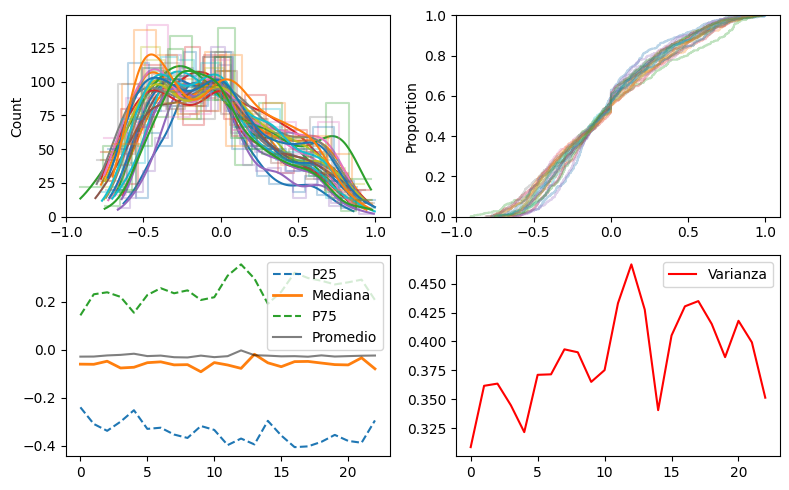

In [27]:
print ("Estadísticas para los jugadores")
fig, axes = plt.subplots(2, 2, figsize=(8, 5)) 
t25_pl, t50_pl, t75_pl, prom_pl, var_pl=mm.estadisticas(lista_dfs_players, axes)
plt.tight_layout() 
plt.show()

In [28]:
mm.crear_tabla_resumen(t25_pl, t50_pl, t75_pl, prom_pl, var_pl)

,t25,t50,t75,promedio,varianza
min,-0.404871,-0.090782,0.144214,-0.031243,0.308671
max,-0.238882,-0.017915,0.356556,-0.001865,0.466581
media,-0.342104,-0.058593,0.250266,-0.024103,0.385884
perc30,-0.372983,-0.062436,0.225806,-0.026853,0.364453
mediana,-0.352399,-0.059719,0.242441,-0.025537,0.386433


Text(0.5, 1.0, 'umbral=0.2, 0.3, 0.5, y 0.6, población>60%')

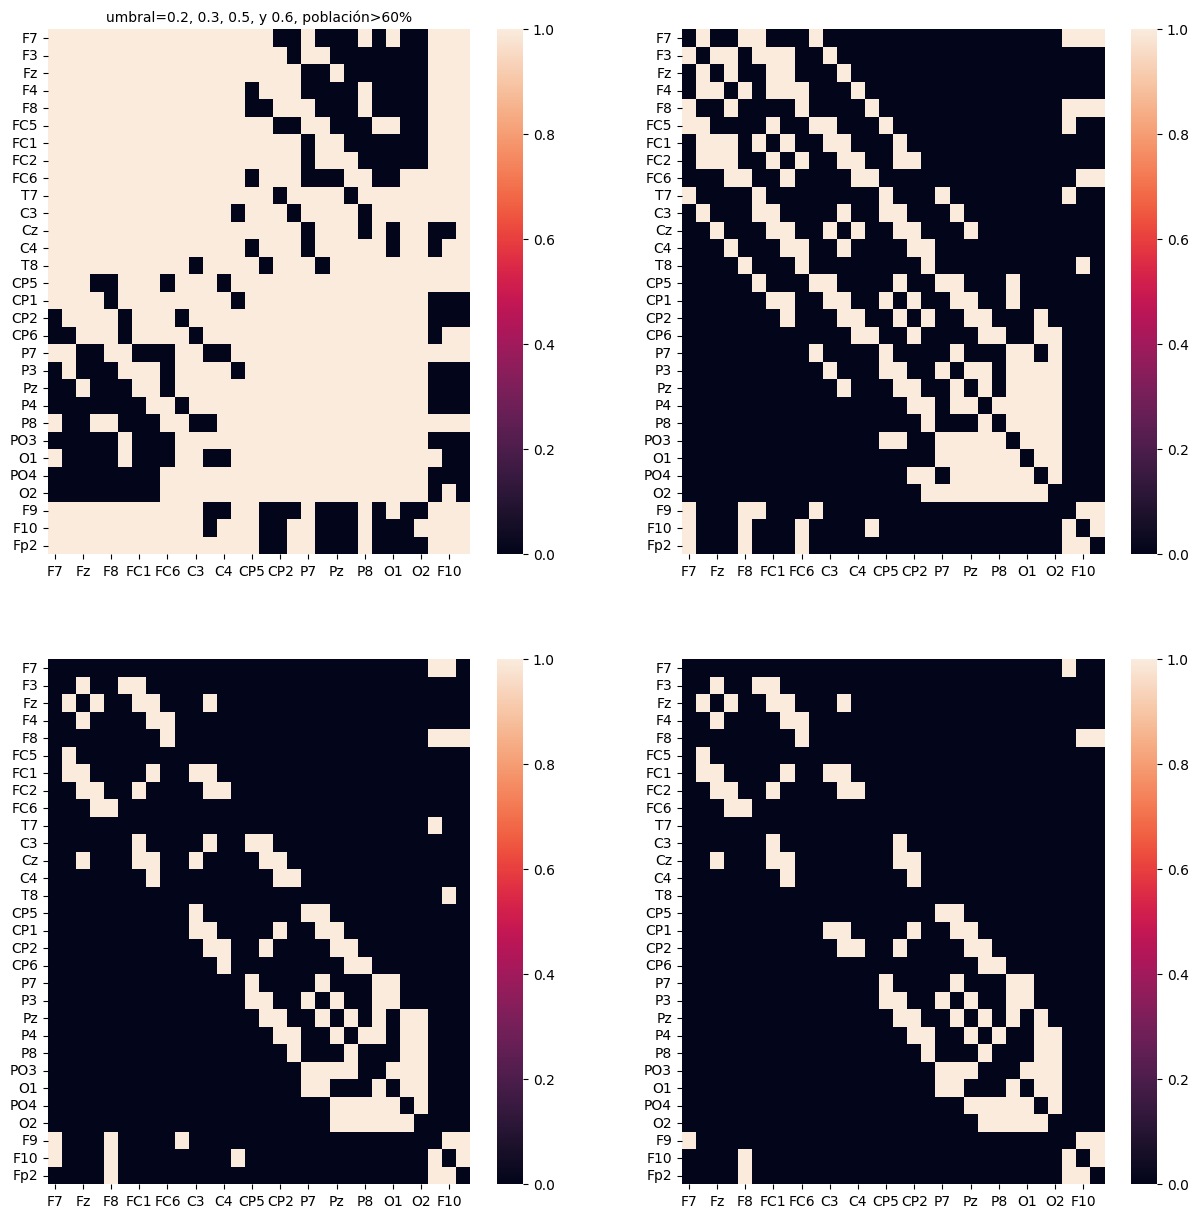

In [29]:
resultados1=mm.capsula(lista_dfs_players, -0.38, 0.6)
resultados2=mm.capsula(lista_dfs_players, 0.25, 0.6)
resultados3=mm.capsula(lista_dfs_players, 0.39, 0.6) ##umbral elegido
resultados4=mm.capsula(lista_dfs_players, 0.47, 0.6)


fig,axes= plt.subplots(2,2, figsize=(15,15))
sns.heatmap(resultados1, ax=axes [0,0])
sns.heatmap(resultados2, ax=axes [0,1])
sns.heatmap(resultados3, ax=axes [1,0])
sns.heatmap(resultados4, ax=axes [1,1])
axes[0,0].set_title("umbral=0.2, 0.3, 0.5, y 0.6, población>60%", fontsize=10)
###

Grafo de los jugadores a 0.39, cumplido por el 60% de la población


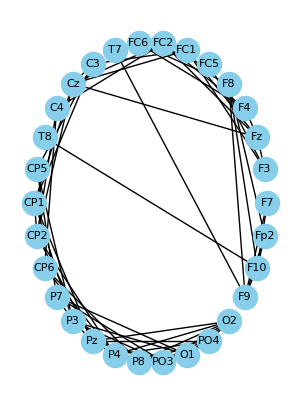

In [30]:
grafo_player=nx.from_pandas_adjacency (resultados3)
fig= plt.figure(figsize=(8,5))
axes=[fig.add_subplot(1,2,1)]
print("Grafo de los jugadores a 0.39, cumplido por el 60% de la población")
mm.dibujar_grafo(grafo_player, axes[0])

In [31]:
mm.metricas(grafo_player)
clust_p, path_length_p, small_world_sigma_p, communities_p, modularity_p, betwenness_p, global_eff_p, local_eff_p, degree_dict_p= mm.metricas(grafo_player)
datos_p = {
    "Clustering Coeff": [clust_p],
    "Longitud Camino": [path_length_p],
    "Small World (Sigma)": [ small_world_sigma_p],
    "Modularidad": [modularity_p],
    "Eficiencia Global": [global_eff_p],
    "Eficiencia Local": [local_eff_p],
    "Num. Comunidades": [len(communities_p)],
    "Hub Principal por intermediacion": [betwenness_p[0][0]] }   

df_metricas = pd.DataFrame(datos_p)
df_metricas

metricas de grafo
metricas de grafo


,Clustering Coeff,Longitud Camino,Small World (Sigma),Modularidad,Eficiencia Global,Eficiencia Local,Num. Comunidades,Hub Principal por intermediacion
0,0.421905,4.009195,0.897575,0.493197,0.384138,0.530357,4,F4


In [32]:
df_metricas.to_excel('Resultados_Grafos.xlsx', index=False)

PermissionError: [Errno 13] Permission denied: 'Resultados_Grafos.xlsx'

In [ ]:
mm. tabla_de_grados (degree_dict_p)  

In [ ]:
mm.medidas_de_centralidad (grafo_player)

In [ ]:
mm.distribución_de_grados (degree_dict_p)

In [ ]:
#¿siguen ley potencia?
mm.ley_potencia (degree_dict_p)

In [ ]:
mm.club_de_ricos(grafo_player)

In [ ]:
##Coordenadas con sistema estandar
montage = mne.channels.make_standard_montage('standard_1020')
def obtener_canales_limpios(mat_content, key_type='observer'):
    struct = mat_content[key_type][0, 0]
    raw_clab = struct['clab']
    lista_canales = [str(item[0]) for item in raw_clab.flatten()]
    return lista_canales
pos_3d = montage.get_positions()['ch_pos']
canales=obtener_canales_limpios(first_file_content, key_type='observer') ## canales
pos_coordenadas = {}
for canal in canales:
        match = next((k for k in pos_3d.keys() if k.upper() == canal.upper()), None)
        if match:
            pos_coordenadas[canal] = pos_3d[match][:3]
c=pd.DataFrame.from_dict(pos_coordenadas, orient='index')
columnas = ['x', 'y', 'z']
c.columns=columnas
c = c.apply(pd.to_numeric, errors='coerce')

In [ ]:
##Grafo 3d
hub_p= betwenness_p[0][0]
print(f"hub por intermediación {hub_p}")
fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'), 
        fig.add_subplot(2, 2, 2, projection='3d'), 
        fig.add_subplot(2, 2, 3)]
mm.grafo_3d (hub_p, c, axes[0])
mm.grafo_de_comunidades(communities_p, hub_p, c, axes[1])
mm.dibujar_grafo(grafo_player, axes[2])
##3 comunidades, 1 frontal, otra medial y otra posterior

In [ ]:
top_hubs = sorted(degree_dict_p.items(), key=lambda x: x[1], reverse=True)[:3]
hubs_por_grado = [hub[0] for hub in top_hubs]
print (f"hubs_por_grado {hubs_por_grado}")
fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'), 
        fig.add_subplot(2, 2, 2, projection='3d'), 
        fig.add_subplot(2, 2, 3)]
mm.grafo_3d (hubs_por_grado, c, axes[0])
mm.grafo_de_comunidades(communities_p, hubs_por_grado, c, axes[1])
mm.dibujar_grafo(grafo_player, axes[2])

In [ ]:
##subgrafos de comunidades
mm.grafos_comunidades (grafo_player, communities_p)